**Identifying features that influence low-income student success**

by Ben Lacar
<br>
March 2019

Next:
- try both random forest and linear/ridge regression
- apply k-fold cross-validation


In [142]:
# Import packages

import os

# Dataframe munging and statistics
import re
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Data visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline

# Unsupervised learning
from sklearn.decomposition import PCA

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

# Stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import multitest

<IPython.core.display.Javascript object>

In [2]:
# Colors and formatting
# Got Google theme html colors from here https://imagecolorpicker.com
B_beige = "#CDA577"
B_brown = "#643E34"
B_slate = "#3F5B66"
B_dkgray = "#5A7E8E"
B_ltgray = "#6D949B"
B_green = "#01CB8B"
B_lime = "#D3F04A"

B_colors = [B_beige, B_brown, B_slate, B_dkgray, B_ltgray, B_green, B_lime]
B_colors_cat = [B_beige, B_green, B_brown, B_ltgray, B_slate, B_lime, B_dkgray]

# Code formatting Jupyter black
%load_ext nb_black

<IPython.core.display.Javascript object>

# Import data

In [3]:
parent_path = "/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study/"
os.chdir(parent_path)
os.getcwd()

'/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study'

<IPython.core.display.Javascript object>

In [30]:
# Import data from data cleaning
df_state_info_gs_census = pd.read_csv(
    "data/b_intermediate/df_state_info_gs_census_200514.csv", index_col=0
)

<IPython.core.display.Javascript object>

In [41]:
df_state_info_gs_census.shape

(966, 70)

<IPython.core.display.Javascript object>

## Evaluate missing data

Text(0, 0.5, 'No. of features')

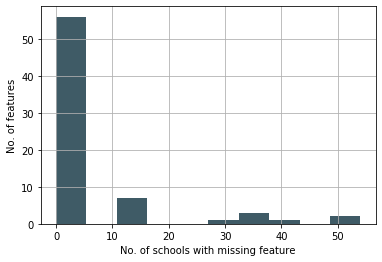

<IPython.core.display.Javascript object>

In [42]:
f, ax1 = plt.subplots()
df_state_info_gs_census.isna().sum().hist(ax=ax1, color=B_slate)
ax1.set_xlabel('No. of schools with missing feature')
ax1.set_ylabel('No. of features')

In [43]:
df_state_info_gs_census.isna().sum().sort_values(ascending=False).head(20)

test_scores_math_LIstudents                                                                          54
test_scores_math_LIstudents_n_students                                                               52
students_per_counselor                                                                               43
Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)    33
Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)                            33
Est.; INCOME_BENEFITS - Total households - Median household income ($)                               33
test_score_rating_notLIstudents                                                                      30
graduation_rates_UCCSU_eligibility_LIstudents                                                        13
graduation_rates_UCCSU_eligibility_allStudents                                                       13
graduation_rates_UCCSU_eligibility_nonLIstudents                

<IPython.core.display.Javascript object>

**What counties and districts are missing values of test scores? (SQL query)**

In [44]:
df_state_info_gs_census.loc[df_state_info_gs_census['test_scores_math_LIstudents'].isna(), :].groupby('County').count().iloc[:, 0]

County
Alameda         4
Colusa          1
Fresno          2
Inyo            1
Kern            1
Los Angeles    34
Mendocino       3
Riverside       2
Sacramento      2
San Diego       1
San Joaquin     1
Siskiyou        1
Yolo            1
Name: NCESDist, dtype: int64

<IPython.core.display.Javascript object>

In [45]:
df_state_info_gs_census.loc[df_state_info_gs_census['test_scores_math_LIstudents'].isna(), :].groupby('County').count().iloc[:, 0].sum()

54

<IPython.core.display.Javascript object>

In [46]:
df_state_info_gs_census.loc[df_state_info_gs_census['test_scores_math_LIstudents'].isna(), :].groupby('District').count().iloc[:, 0]

District
Acton-Agua Dulce Unified            1
Borrego Springs Unified             1
Coachella Valley Unified            2
Delano Joint Union High             1
Esparto Unified                     1
Inyo County Office of Education     1
Laton Joint Unified                 1
Laytonville Unified                 1
Lennox                              1
Los Angeles Unified                30
Mendota Unified                     1
Oakland Unified                     4
Point Arena Joint Union High        1
Pomona Unified                      2
Round Valley Unified                1
Sacramento City Unified             1
Siskiyou Union High                 1
Stockton Unified                    1
Twin Rivers Unified                 1
Williams Unified                    1
Name: NCESDist, dtype: int64

<IPython.core.display.Javascript object>

In [47]:
df_state_info_gs_census = df_state_info_gs_census.dropna().copy()

<IPython.core.display.Javascript object>

In [48]:
print('{0:d} schools have values for all {1:d} features'.format(df_state_info_gs_census.shape[0], df_state_info_gs_census.shape[1]))

814 schools have values for all 70 features


<IPython.core.display.Javascript object>

**Assign the 0/1 value for exceptional schools for SPLICE as the target.**

In [50]:
thresh = df_state_info_gs_census['graduation_rates_UCCSU_eligibility_LIstudents'].mean() + df_state_info_gs_census['graduation_rates_UCCSU_eligibility_LIstudents'].std()
df_state_info_gs_census['splice_high'] = 0
bool_splice_high = df_state_info_gs_census['graduation_rates_UCCSU_eligibility_LIstudents'] > thresh
df_state_info_gs_census.loc[bool_splice_high, 'splice_high'] = 1

<IPython.core.display.Javascript object>

# Split data into train-validation-test

Here are my definitions of these terms:
- train: set for recursive feature selection, using an initial set of model parameters
- validation: set for tuning of hyperparameters (e.g. tree depth)
- test: set that is held out completely until final model valuation (logistic regression vs. random forest)

I'll apply 60-20-20 split. This first split (80/20) is getting the test set separated. The other 80% of the data will be used in finding hyperparameters in a 4-fold cross-validation.

In [52]:
def get_split_data(X, y, testsize):

    # Keep rows only if there are no null values for that feature and target
    k_rows2keep = pd.merge(X, y, left_index=True, right_index=True).notnull().sum(
        axis=1
    ) == (X.shape[1] + 1)
    print(
        "No. of total schools before splitting (no null values for feature set or target): ",
        sum(k_rows2keep),
    )

    X = X.loc[k_rows2keep, :].copy()
    y = y[k_rows2keep].copy()

    # Split data between train and test_(and_holdout?)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=testsize, random_state=19
    )

    return X_train, X_test, y_train, y_test

<IPython.core.display.Javascript object>

**The dataset at this point contains columns that are not features that I want to include in the model (such as street address). The next cell creates a variable that includes the desired features.**

In [66]:
all_features_filt_wcensuscheck = df_state_info_gs_census.columns.tolist()[15::]

<IPython.core.display.Javascript object>

**These other features are targets or features we know highly correlate with the target**.

In [67]:
rm_feat = [
    "graduation_rates_UCCSU_eligibility_allStudents",
    "graduation_rates_UCCSU_eligibility_nonLIstudents",
    "graduation_rates_UCCSU_eligibility_LIstudents",
    "splice_high"
]

all_features_filt_wcensuscheck_notarget = [
    x for x in all_features_filt_wcensuscheck if x not in rm_feat
]
target = "splice_high"

<IPython.core.display.Javascript object>

In [74]:
X = df_state_info_gs_census[all_features_filt_wcensuscheck_notarget].copy()
y = df_state_info_gs_census[target].copy()

<IPython.core.display.Javascript object>

In [75]:
X_train, X_test, y_train, y_test = get_split_data(X, y, 0.2)

No. of total schools before splitting (no null values for feature set or target):  814


<IPython.core.display.Javascript object>

# Logistic regression, target: exceptional schools

Similar to [this blog](https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5)

## Scale data

In [84]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_LR = scaler.transform(X_train)
X_test_LR = scaler.transform(X_test)

<IPython.core.display.Javascript object>

## Run 4-fold cross-validation to get optimal parameters

In [85]:
# Logistic regression parameters to test
random_grid = {
    'penalty' : ['none', 'l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs', 'liblinear']},

<IPython.core.display.Javascript object>

In [100]:
# Instantiate model
log_reg = LogisticRegression()

# Randomized search using 4-fold cross-validation
log_reg_random = RandomizedSearchCV(
    estimator=log_reg,  # the model
    param_distributions=random_grid,  # from above
    n_iter=5,  # no. of parameter settings sampled
    cv=4,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring="f1",  
    return_train_score=True,  # computationally expensive, but output here for insight
)

log_reg_best = log_reg_random.fit(X_train_LR, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.0s finished


<IPython.core.display.Javascript object>

In [102]:
log_reg_best.best_estimator_.get_params()

{'C': 0.08858667904100823,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

<IPython.core.display.Javascript object>

In [125]:
log_reg_best.best_params_

{'solver': 'liblinear', 'penalty': 'l2', 'C': 0.08858667904100823}

<IPython.core.display.Javascript object>

## Evalute optimized parameters on test (hold out) set

In [126]:
log_reg_best = LogisticRegression(**log_reg_best.best_params_)

<IPython.core.display.Javascript object>

In [127]:
log_reg_best.fit(X_train_LR, y_train)
y_pred_LR = log_reg_best.predict(X_test_LR)
df_eval_LR = pd.DataFrame({"test": y_test, "pred": y_pred_LR})

<IPython.core.display.Javascript object>

In [129]:
confusion_matrix(df_eval_LR['test'], df_eval_LR['pred'])

array([[144,   0],
       [ 14,   5]])

<IPython.core.display.Javascript object>

In [112]:
print(classification_report(df_eval_LR['test'], df_eval_LR['pred']))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       144
           1       1.00      0.26      0.42        19

    accuracy                           0.91       163
   macro avg       0.96      0.63      0.69       163
weighted avg       0.92      0.91      0.89       163



<IPython.core.display.Javascript object>

Recall: 0.2632
Accuracy: 0.9141
Precision: 1.0000
[[144   0]
 [ 14   5]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       144
           1       1.00      0.26      0.42        19

    accuracy                           0.91       163
   macro avg       0.96      0.63      0.69       163
weighted avg       0.92      0.91      0.89       163



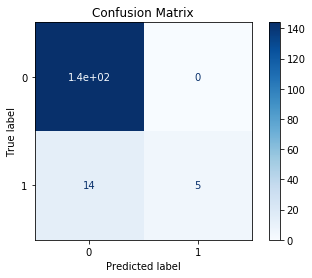

<IPython.core.display.Javascript object>

In [133]:
# Compute and print the confusion matrix and classification report
print('Recall: %.4f' %metrics.recall_score(df_eval_LR['test'], df_eval_LR['pred']))
print('Accuracy: %.4f' %log_reg_best.score(X_test_LR, y_test))
print('Precision: %.4f' %metrics.precision_score(df_eval_LR['test'], df_eval_LR['pred']))
print(confusion_matrix(df_eval_LR['test'], df_eval_LR['pred']))
print(classification_report(df_eval_LR['test'], df_eval_LR['pred']))

f, ax1 = plt.subplots()
plot_confusion_matrix(log_reg_best, X_test_LR, y_test, labels=None, 
                             sample_weight=None, normalize=None, display_labels=None, 
                             include_values=True, xticks_rotation='horizontal', 
                             values_format='d', cmap=plt.cm.Blues, ax=ax1)
ax1.set_title('Confusion Matrix');

## Most important features by logistic regression coefficients

                                                 name     coeff
34                                         enrollment -0.213224
15  %; INDUSTRY - Civilian employed pop. 16 yrs an... -0.211560
2             %; INCOME_BENEFITS - w/ Social Security -0.197747
6   Est.; INCOME_BENEFITS - w/ cash public assista... -0.196498
24  %; INDUSTRY - Civilian employed pop. 16 yrs an... -0.196252
41                             students_per_counselor -0.194310
7   %; HEALTH_INS_COVERAGE - Civilian noninstituti... -0.156741
25  %; INDUSTRY - Civilian employed pop. 16 yrs an... -0.142736
32  %; EMPLOY_STATUS - Females 16 yrs and up - In ... -0.137524
14  %; WORK_COMMUTE - Workers 16 yrs and up - Work... -0.132360
11  %; WORK_COMMUTE - Workers 16 yrs and up - Car,... -0.099726
49             test_scores_math_LIstudents_n_students -0.099427
42                        pct_teachers_3years_or_more -0.098606
4   Est.; INCOME_BENEFITS - Total households - Med... -0.087175
43                       pct_teachers_wh

Text(0.5, 1.0, 'Feature importance Log Reg')

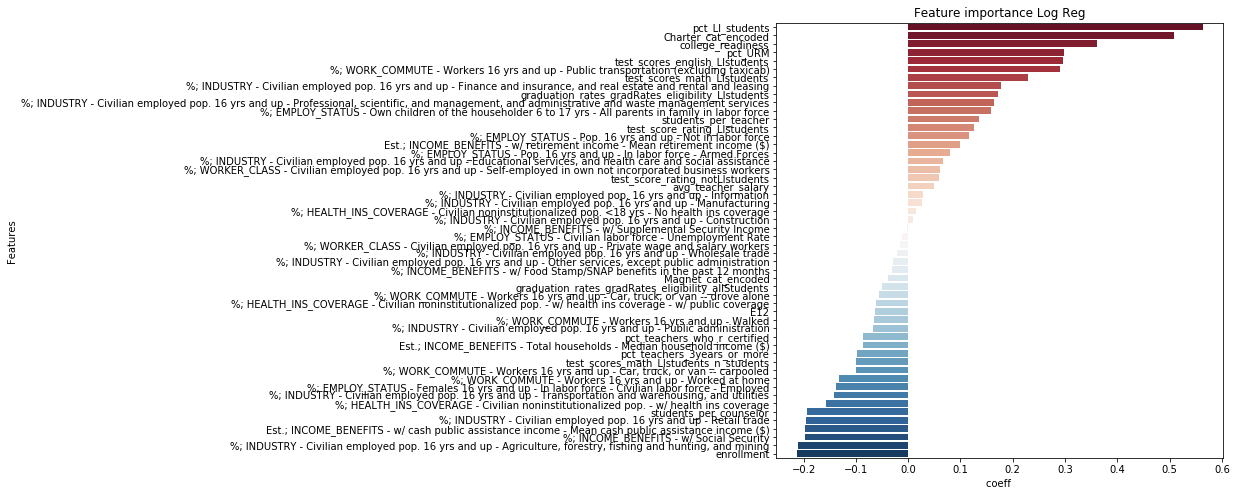

<IPython.core.display.Javascript object>

In [137]:
# calculate feature importance (coeff of logreg)
feature_importance = pd.DataFrame()
feature_importance['name'] = all_features_filt_wcensuscheck_notarget
feature_importance['coeff'] = log_reg_best.coef_[0]
print(feature_importance.sort_values(by=['coeff']))

# plot feature importance (horizontal)

f, ax1 = plt.subplots(figsize=(8,8))
sns.barplot(x='coeff', y='name', data=feature_importance.sort_values(by='coeff', ascending=False), palette='RdBu', ax=ax1)
ax1.set_xlabel('coeff ')
ax1.set_ylabel('Features')
ax1.set_title('Feature importance Log Reg')
#ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')

# RF classification, target: exceptional schools

Standardizing features is not necessary for random forest.

## Run 4-fold cross-validation to get optimal parameters

In [157]:
# Random forest classification parameters to test
random_grid = {
    'n_estimators': [50, 100, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5, 7],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf':[1, 2, 4],
    'class_weight':['balanced']}

<IPython.core.display.Javascript object>

In [158]:
# Instantiate model
rf = RandomForestClassifier()

# Randomized search using 4-fold cross-validation
rf_random = RandomizedSearchCV(
    estimator=rf,  # the model
    param_distributions=random_grid,  # from above
    n_iter=5,  # no. of parameter settings sampled
    cv=4,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring="f1",  
    return_train_score=True,  # computationally expensive, but output here for insight
)

rf_best = rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.4s finished


<IPython.core.display.Javascript object>

In [159]:
rf_best.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

<IPython.core.display.Javascript object>

In [160]:
rf_best.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': 4,
 'criterion': 'entropy',
 'class_weight': 'balanced'}

<IPython.core.display.Javascript object>

## Evalute optimized parameters on test (hold out) set

In [161]:
rf_best = RandomForestClassifier(**rf_best.best_params_)

<IPython.core.display.Javascript object>

In [162]:
rf_best.fit(X_train, y_train)
y_pred_RF = rf_best.predict(X_test)
df_eval_RF = pd.DataFrame({"test": y_test, "pred": y_pred_RF})

<IPython.core.display.Javascript object>

Recall: 0.5263
Accuracy: 0.5337
Precision: 0.7143
[[140   4]
 [  9  10]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       144
           1       0.71      0.53      0.61        19

    accuracy                           0.92       163
   macro avg       0.83      0.75      0.78       163
weighted avg       0.91      0.92      0.91       163



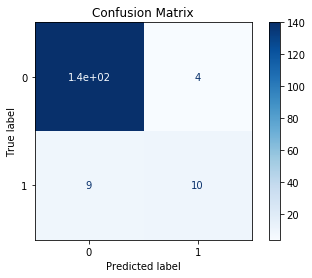

<IPython.core.display.Javascript object>

In [167]:
# Compute and print the confusion matrix and classification report
print('Recall: %.4f' %metrics.recall_score(df_eval_RF['test'], df_eval_RF['pred']))
print('Accuracy: %.4f' %log_reg_best.score(X_test, y_test))
print('Precision: %.4f' %metrics.precision_score(df_eval_RF['test'], df_eval_RF['pred']))
print(confusion_matrix(df_eval_RF['test'], df_eval_RF['pred']))
print(classification_report(df_eval_RF['test'], df_eval_RF['pred']))

f, ax1 = plt.subplots()
plot_confusion_matrix(rf_best, X_test, y_test, labels=None, 
                             sample_weight=None, normalize=None, display_labels=None, 
                             include_values=True, xticks_rotation='horizontal', 
                             values_format='d', cmap=plt.cm.Blues, ax=ax1)
ax1.set_title('Confusion Matrix');

## Most important features from random forest

In [169]:
features = all_features_filt_wcensuscheck_notarget

<IPython.core.display.Javascript object>

In [173]:
feature_imp.head()

%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)    0.091596
Charter_cat_encoded                                                                    0.079627
E12                                                                                    0.079055
test_scores_english_LIstudents                                                         0.066396
enrollment                                                                             0.059162
dtype: float64

<IPython.core.display.Javascript object>

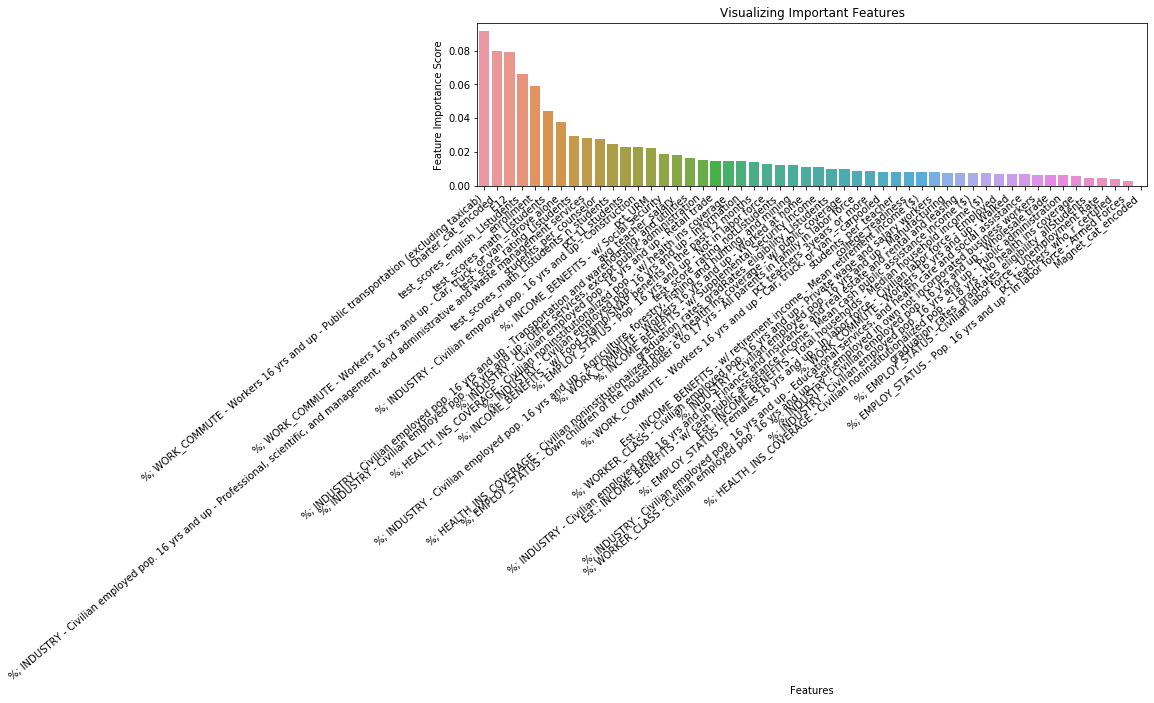

<IPython.core.display.Javascript object>

In [172]:
feature_imp = pd.Series(rf_best.feature_importances_,index=features).sort_values(ascending=False)

# Creating a bar plot
f, ax1 = plt.subplots(figsize=(12,3))
sns.barplot(y=feature_imp, x=feature_imp.index, ax=ax1)

# Add labels to your graph
ax1.set_xlabel('Features')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha='right')

ax1.set_ylabel('Feature Importance Score')
ax1.set_title('Visualizing Important Features');


# RF regression with SPLICE as the target

- Used RF to be allow for possibly correlated features (despite filtering above)
- Splitting on MSE

- Use Gridsearch
- Apply train-validation-test split 



## Generate a train

## Recursive feature selection

- Example here from [KH article](https://towardsdatascience.com/convert-forrest-convert-99eb026f48a9) for train/test/validation 
- [ISLR chapter](https://link.springer.com/chapter/10.1007/978-1-4614-7138-7_5#Sec1)
- [StackExchange post](https://stats.stackexchange.com/questions/359553/choice-of-hyper-parameters-for-recursive-feature-elimination-svm)

### Using default random forest regression to start

In [24]:
from sklearn.feature_selection import RFECV

<IPython.core.display.Javascript object>

In [26]:
estimator = RandomForestRegressor()
estimator

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

<IPython.core.display.Javascript object>

In [ ]:
selector = RFECV(estimator, step=1, cv=5)

In [ ]:
estimato

## Running with grid search

**Run a hyperparameter grid search**

See [here](https://scikit-learn.org/stable/modules/grid_search.html)
- try randomized parameter optimization since more values can be tested
- try doing multiple metrics - R2, MSE, etc.
- note: don't have to do pruning because of RF design (see [here](https://stats.stackexchange.com/questions/36298/why-is-pruning-not-needed-for-random-forest-trees))

In [422]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=50, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ["auto", "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

<IPython.core.display.Javascript object>

**Example to show how to get evaluation metrics**

In [423]:
# Instantiate model - note haven't used oob_scorebool parameter
rf = RandomForestRegressor()

# Randomized search using 5-fold cross-validation
rf_random = RandomizedSearchCV(
    estimator=rf,  # the model
    param_distributions=random_grid,  # from above
    n_iter=5,  # no. of paramter settings sampled
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    refit=False,
    scoring=[
        "r2",
        "neg_root_mean_squared_error",
    ],  # look at multiple evaluation metrics
    return_train_score=True,  # computationally expensive, but output here for insight
)

rf_random.fit(X_train_rf, y_train_rf)

# y_pred = rf.predict(X_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   34.8s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

<IPython.core.display.Javascript object>

In [424]:
df_cv_results = pd.DataFrame(rf_random.cv_results_)
df_cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.180434      0.000722         0.012598        0.000181   
1       1.497859      0.011244         0.078719        0.002499   
2       6.188754      0.089036         0.079011        0.002345   
3       4.858905      0.030372         0.211137        0.000462   
4       9.838721      0.588033         0.094349        0.034168   

  param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                 50                      10                      2   
1                483                      10                      4   
2                483                       2                      2   
3               1350                       5                      1   
4                916                      10                      1   

  param_max_features param_max_depth param_bootstrap  ...  \
0               sqrt              50            True  ...   
1               sqrt              90           False  ...   
2               auto              60           False  ...   
3               sqrt              30            True  ...   
4               auto              80           False  ...   

  split1_test_neg_root_mean_squared_error  \
0                              -13.344600   
1                              -12.475232   
2                              -17.968927   
3                              -12.783770   
4                              -17.478811   

   split2_test_neg_root_mean_squared_error  \
0                               -12.244979   
1                               -12.221827   
2                               -15.088104   
3                               -12.252487   
4                               -14.425920   

   mean_test_neg_root_mean_squared_error  \
0                             -13.074302   
1                             -12.627621   
2                             -16.478725   
3                             -12.739824   
4                             -16.160745   

   std_test_neg_root_mean_squared_error  \
0                              0.598149   
1                              0.408028   
2                              1.178197   
3                              0.381238   
4                              1.280704   

   rank_test_neg_root_mean_squared_error  \
0                                      3   
1                                      1   
2                                      5   
3                                      2   
4                                      4   

   split0_train_neg_root_mean_squared_error  \
0                                 -7.140628   
1                                 -4.856307   
2                                 -3.039072   
3                                 -5.085033   
4                                 -4.483023   

   split1_train_neg_root_mean_squared_error  \
0                                 -7.835275   
1                                 -5.751764   
2                                 -2.939779   
3                                 -5.605779   
4                                 -4.268337   

   split2_train_neg_root_mean_squared_error  \
0                                 -7.607125   
1                                 -5.349721   
2                                 -3.175086   
3                                 -5.444686   
4                                 -5.640106   

   mean_train_neg_root_mean_squared_error  \
0                               -7.527676   
1                               -5.319264   
2                               -3.051312   
3                               -5.378499   
4                               -4.797155   

   std_train_neg_root_mean_squared_error  
0                               0.289099  
1                               0.366202  
2                               0.096453  
3                               0.217684  
4                               0.602465  

[5 rows x 33 columns]

<IPython.core.display.Javascript object>

**Running to get real results**

In [425]:
# Instantiate model - note haven't used oob_scorebool parameter
rf = RandomForestRegressor()

# Rn search using 5-fold cross-validation
rf_random = RandomizedSearchCV(
    estimator=rf,  # the model
    param_distributions=random_grid,  # from above
    n_iter=100,  # no. of paramter settings sampled
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

rf_random.fit(X_train_rf, y_train_rf)

# y_pred = rf.predict(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [ ]:
rf_random.best_params_

This takes a while

## Evaluating multiple models

In [ ]:
# Code from Shaga

# alg_names = [
'Logistic Regression',
#'Support Vector Machines',
'Decision Tree',
'Random Forest',
#'GBDT'
]


# Initialize the ML algorithms
models = {}
for name in alg_names:
if name == 'Logistic Regression':
models[name] = LogisticRegression()
elif name == 'Decision Tree':
models[name] = DecisionTreeClassifier()
elif name == 'Support Vector Machines':
models[name] = SVC()
elif name == 'Random Forest':
models[name] = RandomForestClassifier()



# hyper-paramters for all algorithms
params = {}
for name in alg_names:
if name == 'Logistic Regression':    # change to Linear
params[name] = {
'penalty':['l2'],
'C':[.1, 1.0, 10],
'solver':['lbfgs'],#, 'newton-cg', 'sag', 'saga'],
'max_iter':[10000],
'class_weight':['balanced']
}
elif name == 'Decision Tree':
params[name] = {
'criterion':['gini','entropy'],
'max_depth':[2,3,4],
'class_weight':['balanced']
}
elif name == 'Support Vector Machines':
params[name] = {
'C':[.1, 1, 10],
'kernel':['rbf', 'linear', 'poly'],
'class_weight':['balanced']
}
elif name == 'Random Forest':
params[name] = {
'n_estimators': [50, 100, 500],
'criterion': ['gini', 'entropy'],   # change to regression
'max_depth': [2, 3, 4, 5, 7],
'class_weight':['balanced']
}

### Tune the hyper-parameters with 10-Fold Cross Validation

# then train all algorithms based on ROC-AUC
model_opt = {}


# Train the ML algorithms
for name in alg_names:
print ("Training the " + name + " algorithm...")
model_opt[name] = GridSearchCV( models[name], params[name], cv=10, scoring='precision')

model_opt[name].fit(X_train, y_train)

print ("\n TRAINING IS DONE!! \n")
# Find the scores of each algorithm

## Evaluating with my original code

### RF with 100 trees

In [426]:
def run_randomforest_v0(X_train, y_train, X_test, y_test):
    # Instantiate model with 100 decision trees
    rf = RandomForestRegressor(n_estimators=100, random_state=19,)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    df_eval = pd.DataFrame({"test": y_test, "pred": y_pred})

    return rf, df_eval

<IPython.core.display.Javascript object>

In [427]:
rf_v0, df_eval_v0 = run_randomforest_v0(X_train_rf, y_train_rf, X_test_rf, y_test_rf)

<IPython.core.display.Javascript object>

In [428]:
X_train_rf.shape

(495, 50)

<IPython.core.display.Javascript object>

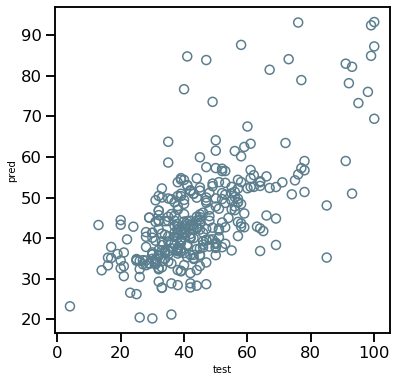

<IPython.core.display.Javascript object>

In [429]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
scatter_plot_open_circles(df_eval_v0, "test", "pred", ax1)

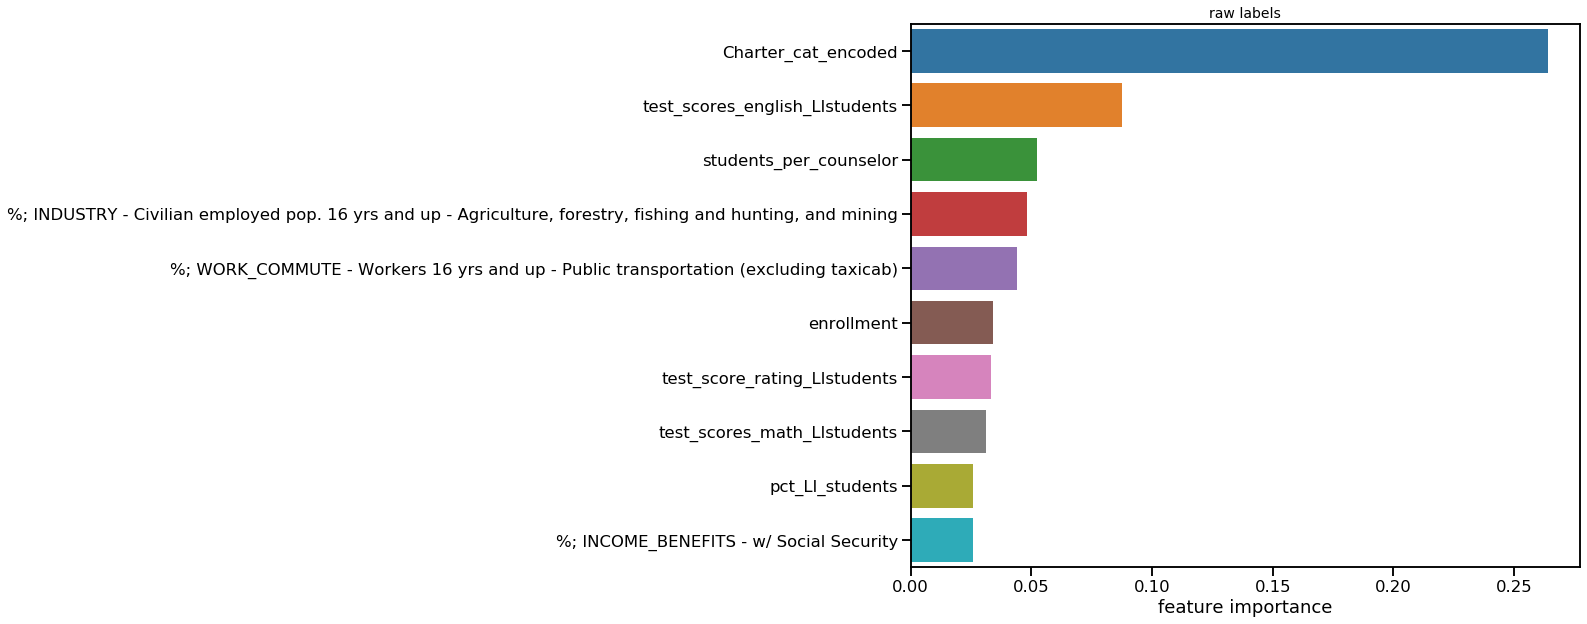

<IPython.core.display.Javascript object>

In [430]:
# Show most important features
features = X_train_rf.columns.tolist()
feature_imp = pd.Series(rf_v0.feature_importances_, index=features).sort_values(ascending=False)

# Creating a bar plot
#f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,16))
f, (ax1) = plt.subplots(1, 1, figsize=(12,10))

#ax1 = 
sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10], ax=ax1)
ax1.set_title('raw labels')
ax1.set_xlabel('feature importance', fontsize=18);

# sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10], ax=ax2)
# new_labels = ['% college eligible - all students', 
#               '% low income students', 
#               '% industry - professional, scientific, management', 
#               'math test scores (all students)', 
#               'avg. teacher salary', 
#               'English test scores (all students)', 
#               '% with supplemental security income', 
#               'mean retirement income', 
#               '% income $35-50K', 
#               '% not in labor force with health insurance coverage']
# ax2.set_yticklabels(new_labels)
# ax2.set_xlabel('feature importance', fontsize=18);
# ax1.set_xticklabels(new_labels, rotation=45, ha='right');
#ax1.set_xticklabels(range(1,11));
#ax1.legend(new_labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize=10);


In [431]:
# Top 10
feature_imp[0:10]

Charter_cat_encoded                                                                                            0.264099
test_scores_english_LIstudents                                                                                 0.087552
students_per_counselor                                                                                         0.052315
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining    0.048243
%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)                            0.044014
enrollment                                                                                                     0.034129
test_score_rating_LIstudents                                                                                   0.033262
test_scores_math_LIstudents                                                                                    0.031363
pct_LI_students                         

<IPython.core.display.Javascript object>

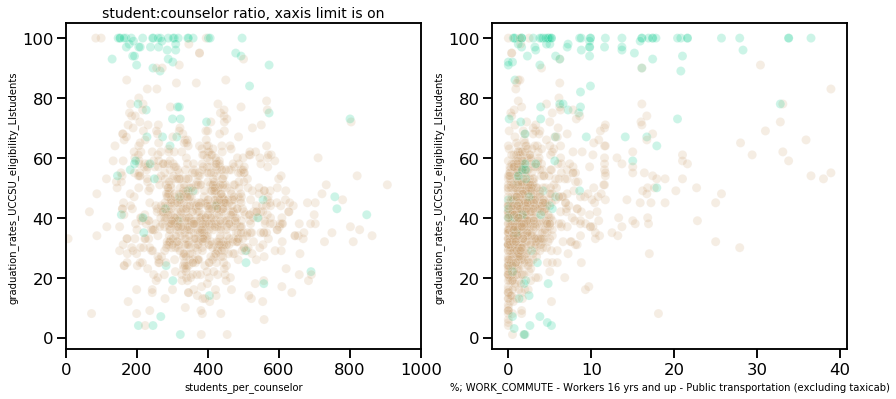

<IPython.core.display.Javascript object>

In [432]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(
    data=df_state_info_gs_census,
    x="students_per_counselor",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    hue="Charter_cat_encoded",
    palette=[B_beige, B_green],
    ax=ax1,
    alpha=0.2,
    legend=False,
)

ax1.set_xlim([0, 1000])
ax1.set_title("student:counselor ratio, xaxis limit is on")

sns.scatterplot(
    data=df_state_info_gs_census,
    x="%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    hue="Charter_cat_encoded",
    palette=[B_beige, B_green],
    ax=ax2,
    alpha=0.2,
    legend=False,
)

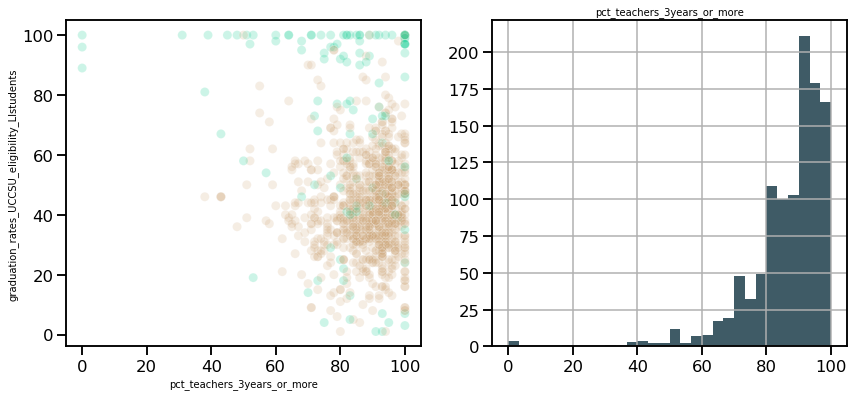

<IPython.core.display.Javascript object>

In [676]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(
    data=df_state_info_gs_census,
    x="pct_teachers_3years_or_more",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    hue="Charter_cat_encoded",
    palette=[B_beige, B_green],
    ax=ax1,
    alpha=0.2,
    legend=False,
)

hist_plot(df_state_info_gs_census, "pct_teachers_3years_or_more", ax=ax2)

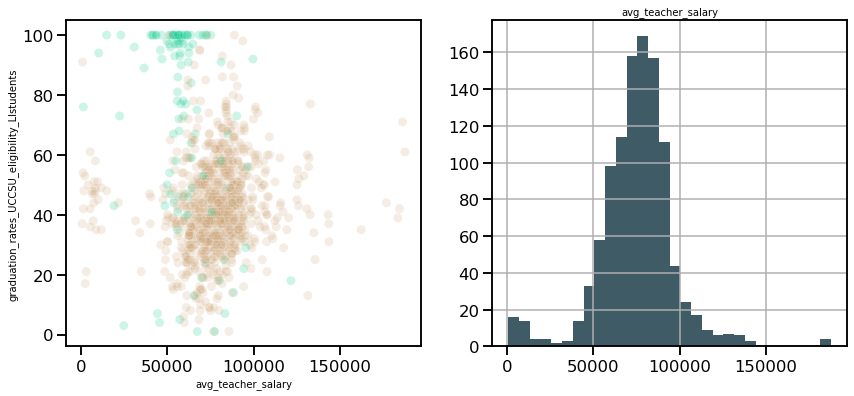

<IPython.core.display.Javascript object>

In [680]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(
    data=df_state_info_gs_census,
    x="avg_teacher_salary",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    hue="Charter_cat_encoded",
    palette=[B_beige, B_green],
    ax=ax1,
    alpha=0.2,
    legend=False,
)

hist_plot(df_state_info_gs_census, "avg_teacher_salary", ax=ax2)

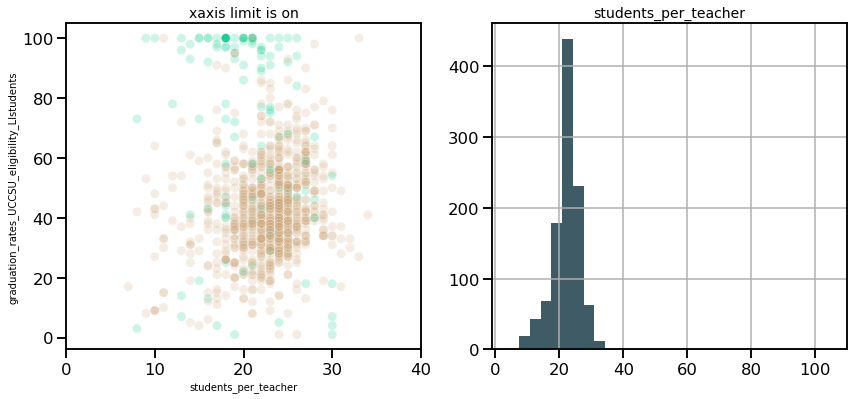

<IPython.core.display.Javascript object>

In [253]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(
    data=df_state_info_gs_census,
    x="students_per_teacher",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    hue="Charter_cat_encoded",
    palette=[B_beige, B_green],
    ax=ax1,
    alpha=0.2,
    legend=False,
)

ax1.set_xlim([0, 40])
ax1.set_title("xaxis limit is on")

hist_plot(df_state_info_gs_census, "students_per_teacher", ax=ax2)

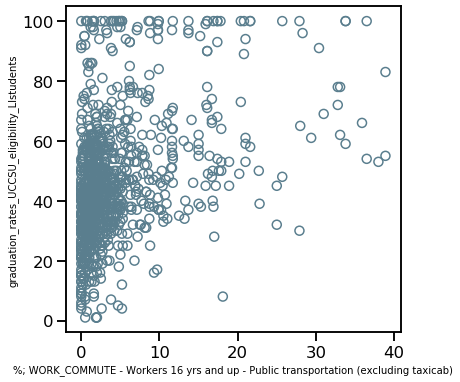

<IPython.core.display.Javascript object>

In [666]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
scatter_plot_open_circles(
    df_state_info_gs_census,
    "%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)",
    "graduation_rates_UCCSU_eligibility_LIstudents",
    ax1,
)

In [165]:
print("R2 score: ", rf_v0.score(X_test_rf, y_test_rf))

R2 score:  0.4449966758497552


<IPython.core.display.Javascript object>

### Use a search to find best parameters

In [433]:
# Number of trees in random forest
n_estimators = range(50, 500, 10)
# Number of features to consider at every split
max_features = ["auto", "sqrt"]
# Maximum number of levels in tree - since I have ~1000 schools
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

<IPython.core.display.Javascript object>

In [434]:
# Instantiate model - note haven't used oob_scorebool parameter
rf = RandomForestRegressor()

# Rn search using 5-fold cross-validation
rf_random = RandomizedSearchCV(
    estimator=rf,  # the model
    param_distributions=random_grid,  # from above
    n_iter=10,  # no. of parameter settings sampled
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    refit=False,
    scoring=[
        "r2",
        "neg_root_mean_squared_error",
    ],  # look at multiple evaluation metrics
    return_train_score=True,  # computationally expensive, but output here for insight
)

rf_random.fit(X_train_rf, y_train_rf)

# This took ~ 10 sec to run


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.7s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

<IPython.core.display.Javascript object>

In [435]:
df_cv_results = pd.DataFrame(rf_random.cv_results_)
df_cv_results.T

0  \
mean_fit_time                                                                       1.00738   
std_fit_time                                                                     0.00786609   
mean_score_time                                                                   0.0502166   
std_score_time                                                                    0.0016789   
param_n_estimators                                                                      300   
param_min_samples_split                                                                  10   
param_min_samples_leaf                                                                    4   
param_max_features                                                                     sqrt   
param_max_depth                                                                          10   
param_bootstrap                                                                        True   
params                                    {'n_estimators': 300, 'min_samples_split': 10,...   
split0_test_r2                                                                     0.411121   
split1_test_r2                                                                     0.511733   
split2_test_r2                                                                     0.470293   
mean_test_r2                                                                       0.464382   
std_test_r2                                                                       0.0412866   
rank_test_r2                                                                              9   
split0_train_r2                                                                    0.812101   
split1_train_r2                                                                    0.759787   
split2_train_r2                                                                    0.789786   
mean_train_r2                                                                      0.787225   
std_train_r2                                                                       0.021434   
split0_test_neg_root_mean_squared_error                                            -13.5115   
split1_test_neg_root_mean_squared_error                                            -12.9871   
split2_test_neg_root_mean_squared_error                                            -12.5728   
mean_test_neg_root_mean_squared_error                                              -13.0238   
std_test_neg_root_mean_squared_error                                               0.384135   
rank_test_neg_root_mean_squared_error                                                     9   
split0_train_neg_root_mean_squared_error                                           -7.81682   
split1_train_neg_root_mean_squared_error                                           -8.60102   
split2_train_neg_root_mean_squared_error                                           -8.30037   
mean_train_neg_root_mean_squared_error                                             -8.23941   
std_train_neg_root_mean_squared_error                                               0.32304   

                                                                                          1  \
mean_fit_time                                                                      0.208116   
std_fit_time                                                                     0.00438205   
mean_score_time                                                                   0.0121229   
std_score_time                                                                  0.000852859   
param_n_estimators                                                                       50   
param_min_samples_split                                                                   2   
param_min_samples_leaf                                                                    1   
param_max_features                                                                     sqrt   
para

<IPython.core.display.Javascript object>

In [436]:
# Return the parameters that are best

bool_best_rank = (df_cv_results["rank_test_neg_root_mean_squared_error"] == 1) & (
    df_cv_results["rank_test_r2"] == 1
)

idx_bool = df_cv_results.index[bool_best_rank][0]
best_params = df_cv_results.loc[idx_bool, "params"]
best_params

{'n_estimators': 210,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 8,
 'bootstrap': True}

<IPython.core.display.Javascript object>

In [437]:
# Add random state to the parameters
best_params["random_state"] = 42
best_params

{'n_estimators': 210,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 8,
 'bootstrap': True,
 'random_state': 42}

<IPython.core.display.Javascript object>

In [438]:
def run_randomforest_v1(X_train, y_train, X_test, y_test, parameters):
    # Use dictionary of parameters - use the double asterisks to unpack
    parameters["random_state"] = 42
    rf = RandomForestRegressor(**parameters)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    df_eval = pd.DataFrame({"test": y_test, "pred": y_pred})

    return rf, df_eval

<IPython.core.display.Javascript object>

In [439]:
rf_v1, df_eval_v1 = run_randomforest_v1(
    X_train_rf, y_train_rf, X_test_rf, y_test_rf, best_params
)

<IPython.core.display.Javascript object>

In [440]:
# Verify the right parameters are being put in
rf_v1

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=210, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'test vs. prediction of SPLICE')

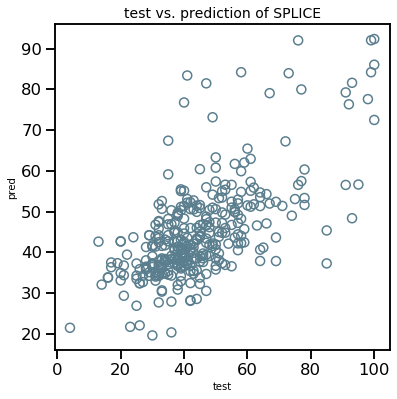

<IPython.core.display.Javascript object>

In [441]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
scatter_plot_open_circles(df_eval_v1, "test", "pred", ax1)
ax1.set_title("test vs. prediction of SPLICE")

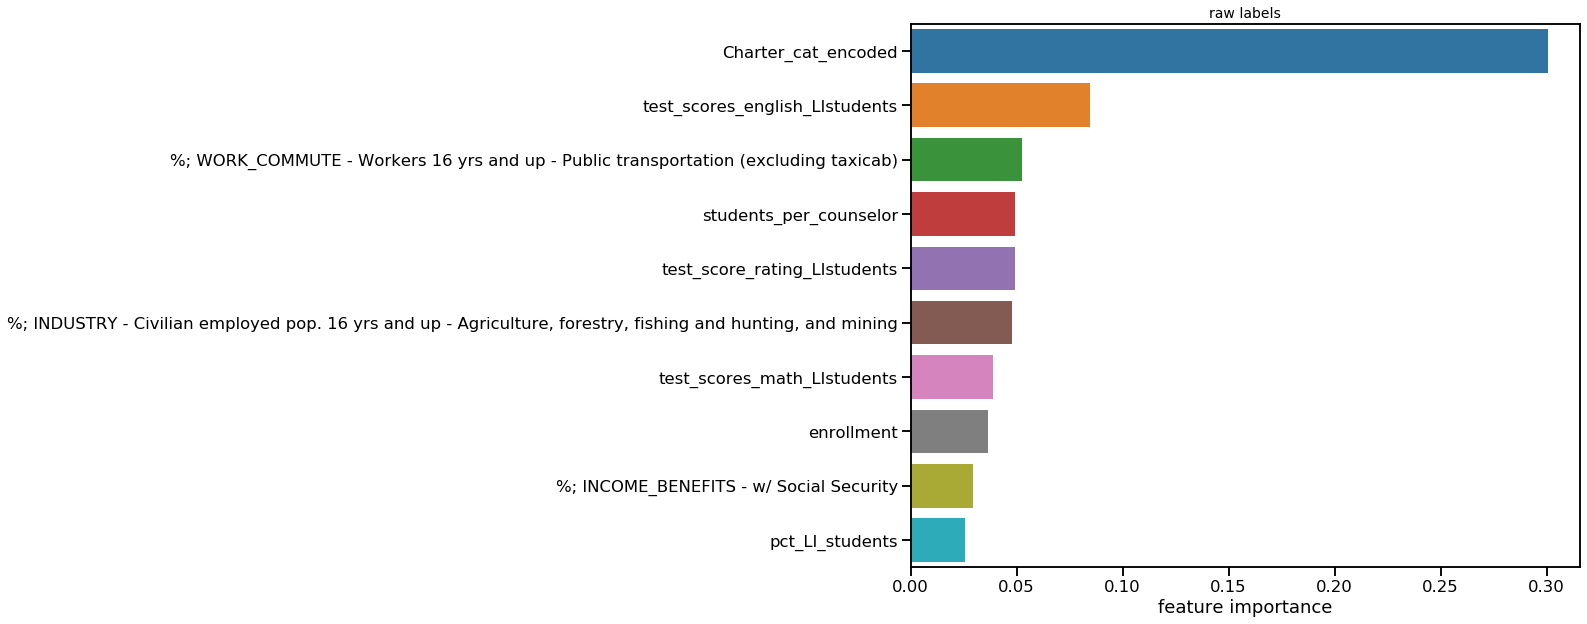

<IPython.core.display.Javascript object>

In [442]:
# Show most important features
features = X_train_rf.columns.tolist()
feature_imp = pd.Series(rf_v1.feature_importances_, index=features).sort_values(ascending=False)

# Creating a bar plot
#f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,16))
f, (ax1) = plt.subplots(1, 1, figsize=(12,10))

#ax1 = 
sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10], ax=ax1)
ax1.set_title('raw labels')
ax1.set_xlabel('feature importance', fontsize=18);

# sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10], ax=ax2)
# new_labels = ['% college eligible - all students', 
#               '% low income students', 
#               '% industry - professional, scientific, management', 
#               'math test scores (all students)', 
#               'avg. teacher salary', 
#               'English test scores (all students)', 
#               '% with supplemental security income', 
#               'mean retirement income', 
#               '% income $35-50K', 
#               '% not in labor force with health insurance coverage']
# ax2.set_yticklabels(new_labels)
# ax2.set_xlabel('feature importance', fontsize=18);
# ax1.set_xticklabels(new_labels, rotation=45, ha='right');
#ax1.set_xticklabels(range(1,11));
#ax1.legend(new_labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize=10);


In [443]:
feature_imp

Charter_cat_encoded                                                                                                                                0.300799
test_scores_english_LIstudents                                                                                                                     0.084532
%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)                                                                0.052728
students_per_counselor                                                                                                                             0.049315
test_score_rating_LIstudents                                                                                                                       0.049254
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining                                        0.048027
test_scores_math_LIstudents                                     

<IPython.core.display.Javascript object>

#### Evaluate with SHAP values

https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

In [444]:
import shap

<IPython.core.display.Javascript object>

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


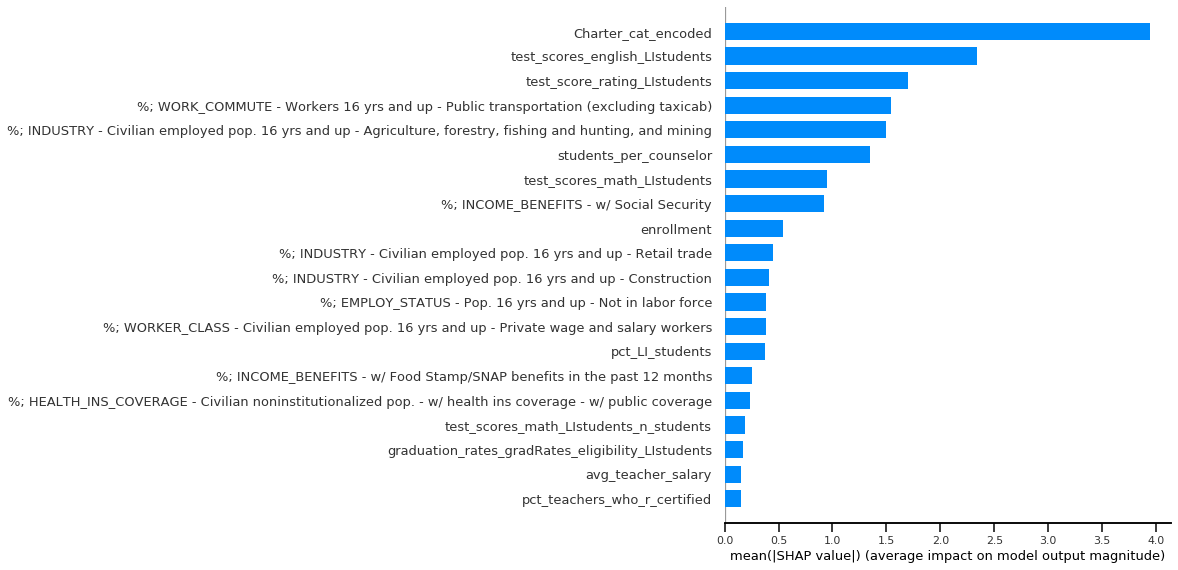

<IPython.core.display.Javascript object>

In [445]:
shap_values = shap.TreeExplainer(rf_v1).shap_values(X_train_rf)
shap.summary_plot(shap_values, X_train_rf, plot_type="bar")

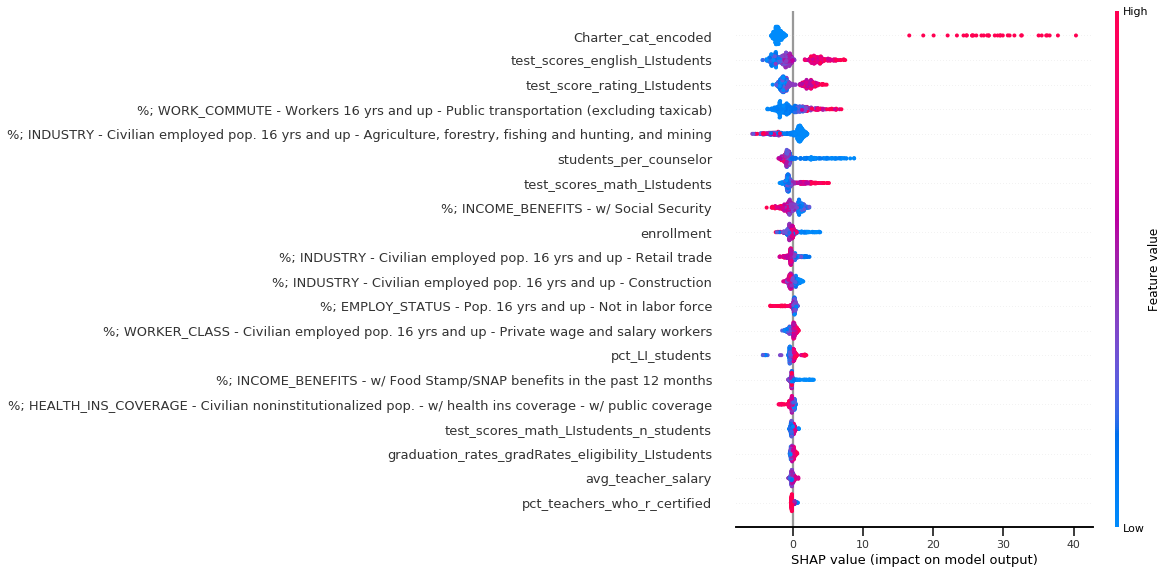

<IPython.core.display.Javascript object>

In [446]:
shap.summary_plot(shap_values, X_train_rf)

In [447]:
def ABS_SHAP(df_shap, df, top_n):
    # import matplotlib as plt
    """
    From blog post
    """

    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop("index", axis=1)

    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i], df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list), pd.Series(corr_list)], axis=1).fillna(
        0
    )
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns = ["Variable", "Corr"]
    corr_df["Sign"] = np.where(corr_df["Corr"] > 0, "red", "blue")

    # Plot it
    shap_abs = np.abs(shap_v)
    k = pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ["Variable", "SHAP_abs"]
    k2 = k.merge(corr_df, left_on="Variable", right_on="Variable", how="inner")
    k2 = k2.sort_values(by="SHAP_abs", ascending=True).tail(
        top_n
    )  # Added top_n to limit features
    colorlist = k2["Sign"]
    ax = k2.plot.barh(
        x="Variable", y="SHAP_abs", color=colorlist, figsize=(20, 16), legend=False,
    )
    ax.set_yticklabels(labels=k2["Variable"], fontsize=24)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)", fontsize=24)
    ax.set_ylabel("")

    # return k2

    # ABS_SHAP(shap_values,X_train,top_n)
    # view rawABS_SHAP hosted with ❤ by GitHub

<IPython.core.display.Javascript object>

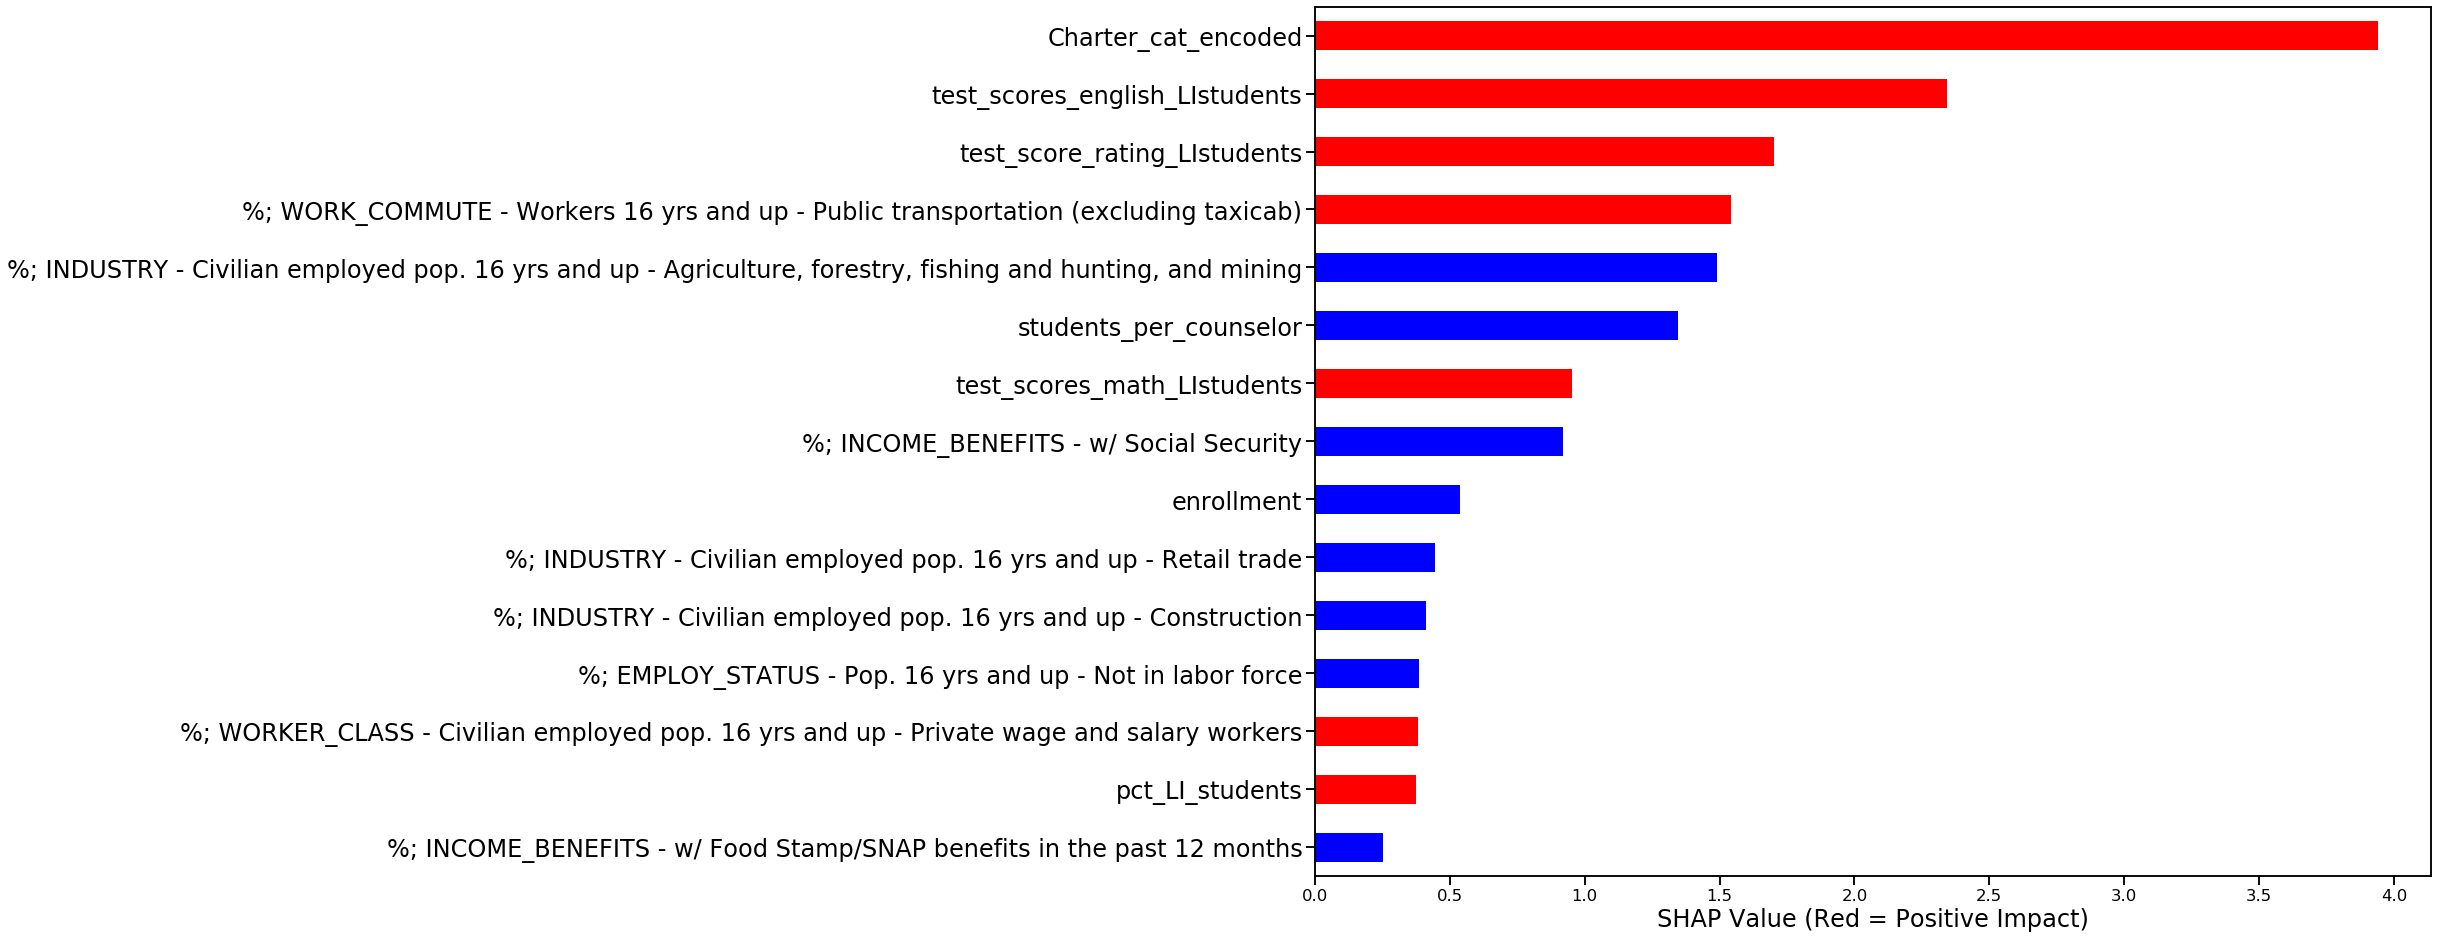

<IPython.core.display.Javascript object>

In [448]:
ABS_SHAP(shap_values, X_train_rf, 15)

### Evaluating with different split

In [182]:
def get_split_data_v1(X, y, testsize):

    # Keep rows only if there are no null values for that feature and target
    k_rows2keep = pd.merge(X, y, left_index=True, right_index=True).notnull().sum(
        axis=1
    ) == (X.shape[1] + 1)
    print(
        "No. of total schools before splitting (no null values for feature set or target): ",
        sum(k_rows2keep),
    )

    X = X.loc[k_rows2keep, :].copy()
    y = y[k_rows2keep].copy()

    # Split data between train and test_(and_holdout?)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=testsize, random_state=42
    )

    return X_train, X_test, y_train, y_test

<IPython.core.display.Javascript object>

In [187]:
(
    X_train_splitv1_rf,
    X_test_splitv1_rf,
    y_train_splitv1_rf,
    y_test_splitv1_rf,
) = get_split_data_v1(X_rf, y_rf, 0.4)

No. of total schools before splitting (no null values for feature set or target):  825


<IPython.core.display.Javascript object>

In [192]:
rf_split_v1_modv1, df_eval_split_v1_modv1 = run_randomforest_v1(
    X_train_splitv1_rf,
    y_train_splitv1_rf,
    X_test_splitv1_rf,
    y_test_splitv1_rf,
    best_params,
)

<IPython.core.display.Javascript object>

In [195]:
features = X_train_splitv1_rf.columns.tolist()
feature_imp = pd.Series(
    rf_split_v1_modv1.feature_importances_, index=features
).sort_values(ascending=False)
feature_imp[0:10]

Charter_cat_encoded                                                                             0.312619
test_scores_math_LIstudents                                                                     0.097150
test_scores_english_LIstudents                                                                  0.037970
%; INCOME_BENEFITS - w/ Social Security                                                         0.035382
enrollment                                                                                      0.025209
%; WORK_COMMUTE - Workers 16 yrs and up - Walked                                                0.024615
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage    0.024261
students_per_counselor                                                                          0.023836
%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)             0.023788
%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the

<IPython.core.display.Javascript object>

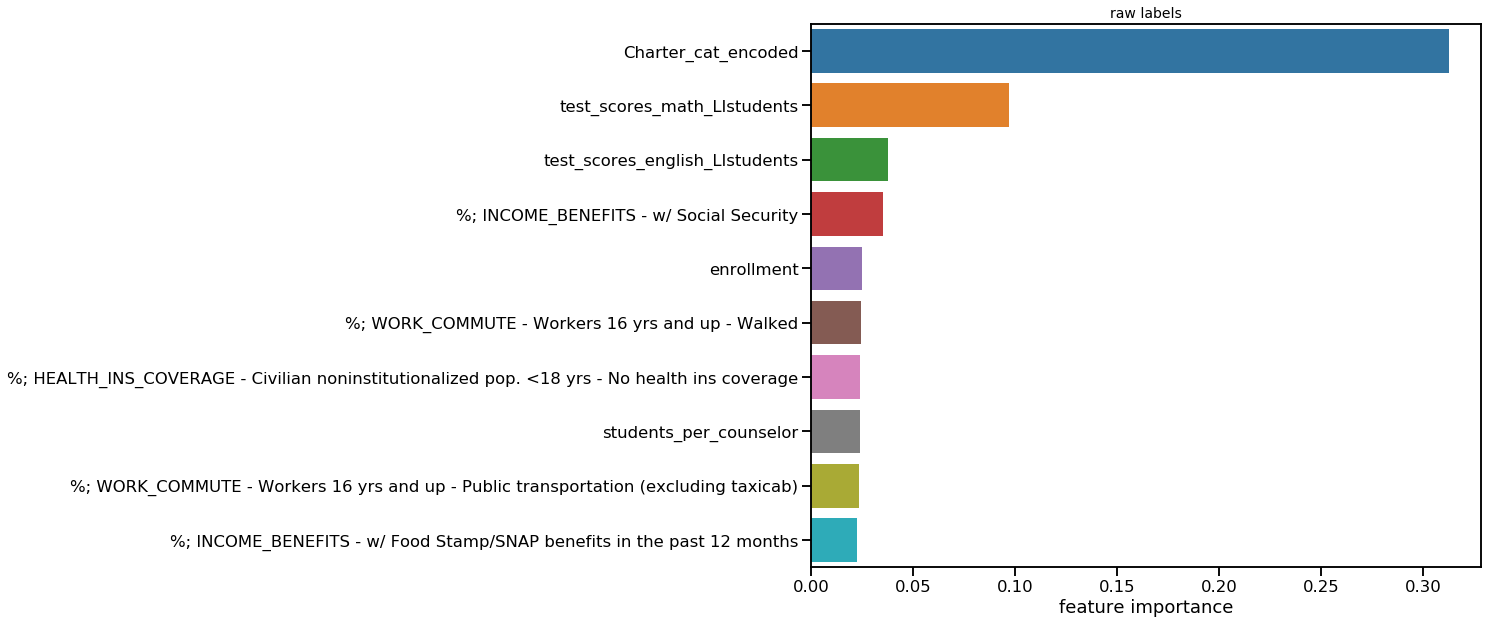

<IPython.core.display.Javascript object>

In [196]:
# Show most important features
features = X_train_splitv1_rf.columns.tolist()
feature_imp = pd.Series(
    rf_split_v1_modv1.feature_importances_, index=features
).sort_values(ascending=False)

# Creating a bar plot
#f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,16))
f, (ax1) = plt.subplots(1, 1, figsize=(12,10))

#ax1 = 
sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10], ax=ax1)
ax1.set_title('raw labels')
ax1.set_xlabel('feature importance', fontsize=18);

# sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10], ax=ax2)
# new_labels = ['% college eligible - all students', 
#               '% low income students', 
#               '% industry - professional, scientific, management', 
#               'math test scores (all students)', 
#               'avg. teacher salary', 
#               'English test scores (all students)', 
#               '% with supplemental security income', 
#               'mean retirement income', 
#               '% income $35-50K', 
#               '% not in labor force with health insurance coverage']
# ax2.set_yticklabels(new_labels)
# ax2.set_xlabel('feature importance', fontsize=18);
# ax1.set_xticklabels(new_labels, rotation=45, ha='right');
#ax1.set_xticklabels(range(1,11));
#ax1.legend(new_labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize=10);


# RF regression, target: SPLICE and gap

## Get split data

In [458]:
# leave all features in
target = "nonLI-LI_UCCSU_eligibility_gap"

<IPython.core.display.Javascript object>

In [459]:
X_rf_gap = df_state_info_gs_census[all_features_filt_wcensuscheck].copy()
y_rf_gap = df_state_info_gs_census[target].copy()

<IPython.core.display.Javascript object>

In [460]:
X_train_rf_gap, X_test_rf_gap, y_train_rf_gap, y_test_rf_gap = get_split_data(
    X_rf_gap, y_rf_gap, 0.4
)

No. of total schools before splitting (no null values for feature set or target):  811


<IPython.core.display.Javascript object>

## Run model with search to find best parameters

In [461]:
# Number of trees in random forest
n_estimators = range(50, 500, 10)
# Number of features to consider at every split
max_features = ["auto", "sqrt"]
# Maximum number of levels in tree - since I have ~1000 schools
max_depth = [2, 3, 4, 5, 6, 7, 8, 9, 10]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

<IPython.core.display.Javascript object>

In [462]:
# Instantiate model - note haven't used oob_scorebool parameter
rf_gap = RandomForestRegressor()

# Rn search using 5-fold cross-validation
rf_gap_random = RandomizedSearchCV(
    estimator=rf_gap,  # the model
    param_distributions=random_grid,  # from above
    n_iter=10,  # no. of parameter settings sampled
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    refit=False,
    scoring=[
        "r2",
        "neg_root_mean_squared_error",
    ],  # look at multiple evaluation metrics
    return_train_score=True,  # computationally expensive, but output here for insight
)

rf_gap_random.fit(X_train_rf_gap, y_train_rf_gap)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.3s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

<IPython.core.display.Javascript object>

In [463]:
df_cv_results = pd.DataFrame(rf_gap_random.cv_results_)
df_cv_results.T

0  \
mean_fit_time                                                                       1.05258   
std_fit_time                                                                     0.00915703   
mean_score_time                                                                   0.0518315   
std_score_time                                                                   0.00135416   
param_n_estimators                                                                      300   
param_min_samples_split                                                                  10   
param_min_samples_leaf                                                                    4   
param_max_features                                                                     sqrt   
param_max_depth                                                                          10   
param_bootstrap                                                                        True   
params                                    {'n_estimators': 300, 'min_samples_split': 10,...   
split0_test_r2                                                                     0.562203   
split1_test_r2                                                                     0.625538   
split2_test_r2                                                                     0.564077   
mean_test_r2                                                                       0.583939   
std_test_r2                                                                       0.0294246   
rank_test_r2                                                                              7   
split0_train_r2                                                                    0.821652   
split1_train_r2                                                                    0.814919   
split2_train_r2                                                                    0.823976   
mean_train_r2                                                                      0.820182   
std_train_r2                                                                     0.00384075   
split0_test_neg_root_mean_squared_error                                             -7.0896   
split1_test_neg_root_mean_squared_error                                            -6.68258   
split2_test_neg_root_mean_squared_error                                            -7.08974   
mean_test_neg_root_mean_squared_error                                              -6.95397   
std_test_neg_root_mean_squared_error                                               0.191902   
rank_test_neg_root_mean_squared_error                                                     7   
split0_train_neg_root_mean_squared_error                                           -4.58251   
split1_train_neg_root_mean_squared_error                                           -4.61466   
split2_train_neg_root_mean_squared_error                                           -4.54657   
mean_train_neg_root_mean_squared_error                                             -4.58125   
std_train_neg_root_mean_squared_error                                             0.0278136   

                                                                                          1  \
mean_fit_time                                                                      0.214135   
std_fit_time                                                                     0.00543677   
mean_score_time                                                                   0.0137739   
std_score_time                                                                   0.00206233   
param_n_estimators                                                                       50   
param_min_samples_split                                                                   2   
param_min_samples_leaf                                                                    1   
param_max_features                                                                     sqrt   
para

<IPython.core.display.Javascript object>

In [464]:
# Return the parameters that are best

bool_best_rank = (df_cv_results["rank_test_neg_root_mean_squared_error"] == 1) & (
    df_cv_results["rank_test_r2"] == 1
)

idx_bool = df_cv_results.index[bool_best_rank][0]
best_params = df_cv_results.loc[idx_bool, "params"]
best_params

{'n_estimators': 240,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 9,
 'bootstrap': True}

<IPython.core.display.Javascript object>

In [465]:
# Add random state to the parameters
best_params["random_state"] = 42
best_params

{'n_estimators': 240,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 9,
 'bootstrap': True,
 'random_state': 42}

<IPython.core.display.Javascript object>

In [466]:
def run_randomforest_v2_gap(X_train, y_train, X_test, y_test, parameters):
    # Use dictionary of parameters - use the double asterisks to unpack
    parameters["random_state"] = 42
    rf = RandomForestRegressor(**parameters)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    df_eval = pd.DataFrame({"test": y_test, "pred": y_pred})

    return rf, df_eval

<IPython.core.display.Javascript object>

In [467]:
rf_gap_v2, df_eval_v2 = run_randomforest_v2_gap(
    X_train_rf_gap, y_train_rf_gap, X_test_rf_gap, y_test_rf_gap, best_params
)

<IPython.core.display.Javascript object>

In [468]:
# Verify the right parameters are being put in
rf_gap_v2

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=240, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'test vs. prediction of SPLICE')

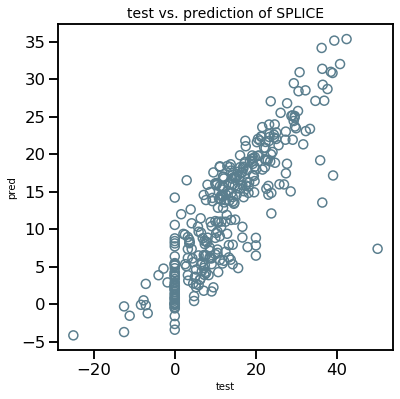

<IPython.core.display.Javascript object>

In [469]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
scatter_plot_open_circles(df_eval_v2, "test", "pred", ax1)
ax1.set_title("test vs. prediction of SPLICE")

## Most important features from model

''

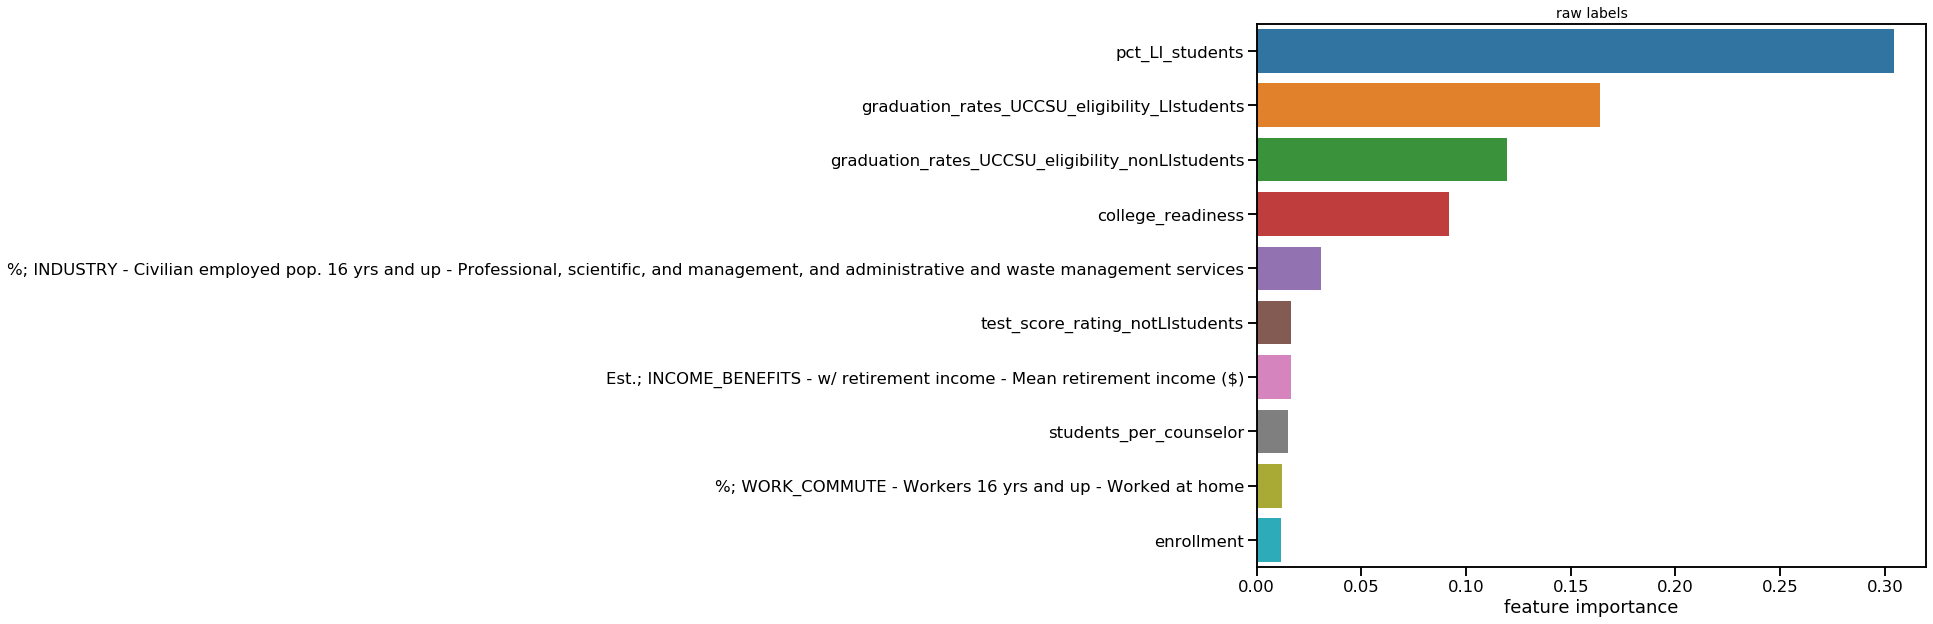

<IPython.core.display.Javascript object>

In [470]:
# Show most important features
features = X_train_rf_gap.columns.tolist()
feature_imp = pd.Series(rf_gap_v2.feature_importances_, index=features).sort_values(ascending=False)

# Creating a bar plot
#f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,16))
f, (ax1) = plt.subplots(1, 1, figsize=(12,10))

#ax1 = 
sns.barplot(x=feature_imp[0:10], y=feature_imp.index[0:10], ax=ax1)
ax1.set_title('raw labels')
ax1.set_xlabel('feature importance', fontsize=18);
;

In [478]:
feature_imp

pct_LI_students                                                                                                                                    0.304554
graduation_rates_UCCSU_eligibility_LIstudents                                                                                                      0.163750
graduation_rates_UCCSU_eligibility_nonLIstudents                                                                                                   0.119698
college_readiness                                                                                                                                  0.091709
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services    0.030807
test_score_rating_notLIstudents                                                                                                                    0.016477
Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement i

<IPython.core.display.Javascript object>

## Most important features from SHAP

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


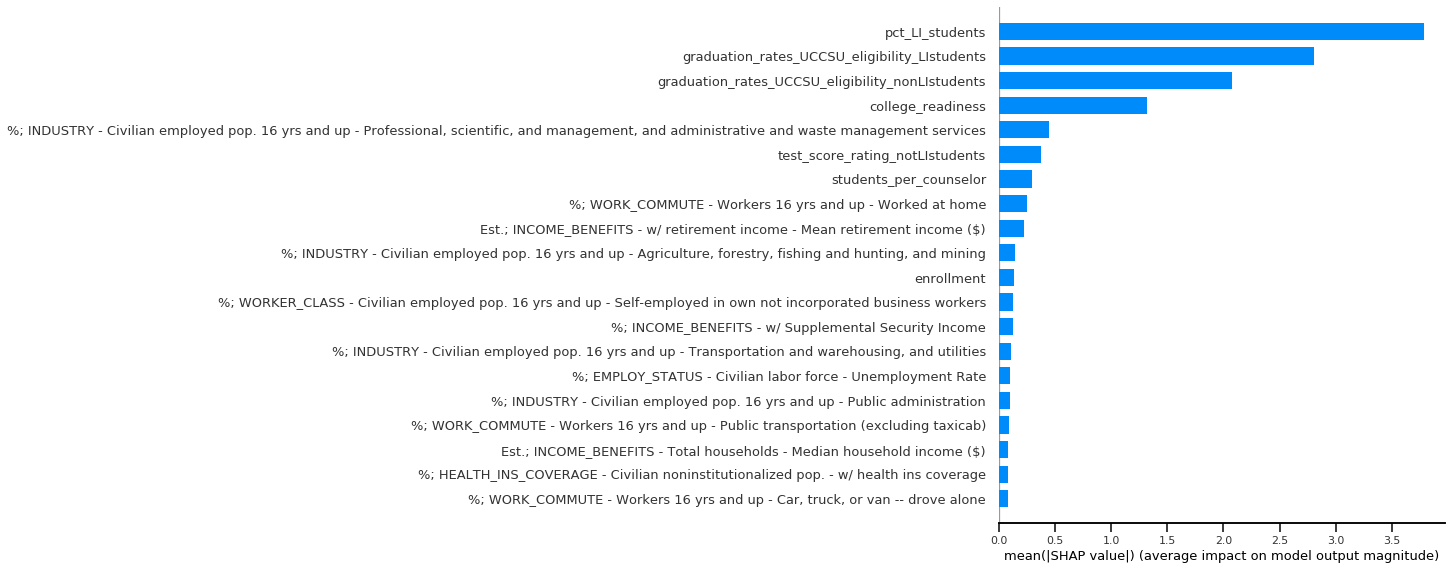

<IPython.core.display.Javascript object>

In [472]:
shap_values = shap.TreeExplainer(rf_gap_v2).shap_values(X_train_rf_gap)
shap.summary_plot(shap_values, X_train_rf_gap, plot_type="bar")

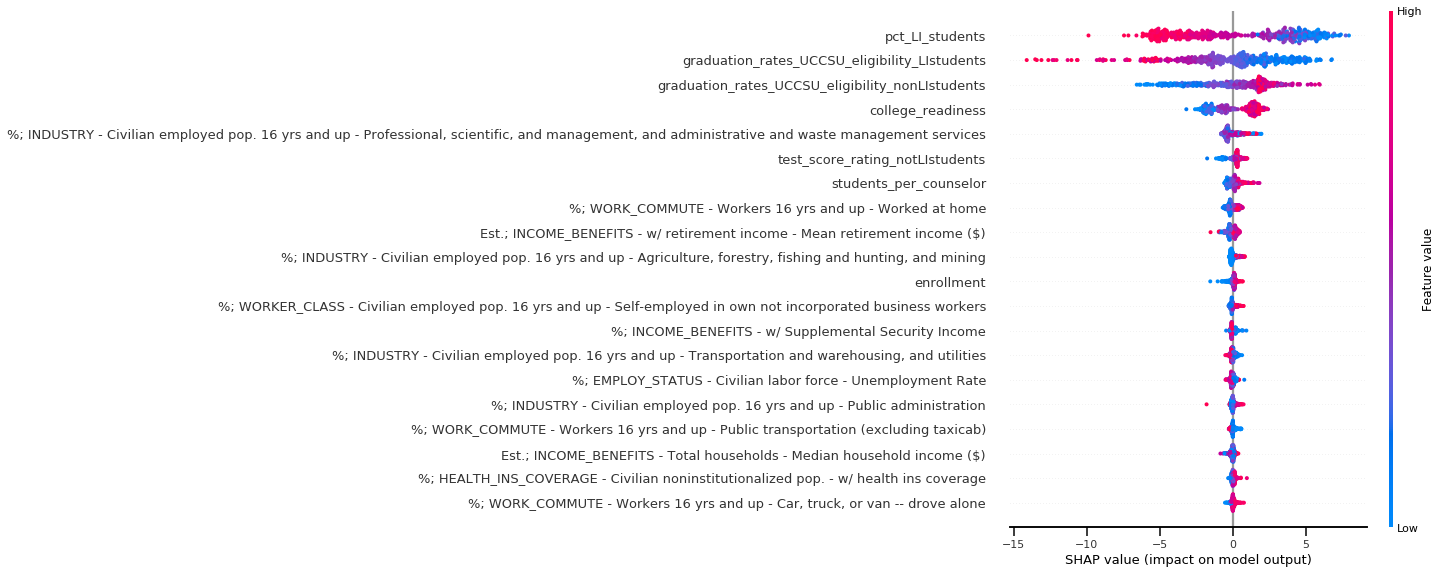

<IPython.core.display.Javascript object>

In [473]:
shap.summary_plot(shap_values, X_train_rf_gap)

In [447]:
def ABS_SHAP(df_shap, df, top_n):
    # import matplotlib as plt
    """
    From blog post
    """

    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop("index", axis=1)

    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i], df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list), pd.Series(corr_list)], axis=1).fillna(
        0
    )
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns = ["Variable", "Corr"]
    corr_df["Sign"] = np.where(corr_df["Corr"] > 0, "red", "blue")

    # Plot it
    shap_abs = np.abs(shap_v)
    k = pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ["Variable", "SHAP_abs"]
    k2 = k.merge(corr_df, left_on="Variable", right_on="Variable", how="inner")
    k2 = k2.sort_values(by="SHAP_abs", ascending=True).tail(
        top_n
    )  # Added top_n to limit features
    colorlist = k2["Sign"]
    ax = k2.plot.barh(
        x="Variable", y="SHAP_abs", color=colorlist, figsize=(20, 16), legend=False,
    )
    ax.set_yticklabels(labels=k2["Variable"], fontsize=24)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)", fontsize=24)
    ax.set_ylabel("")

    # return k2

    # ABS_SHAP(shap_values,X_train,top_n)
    # view rawABS_SHAP hosted with ❤ by GitHub

<IPython.core.display.Javascript object>

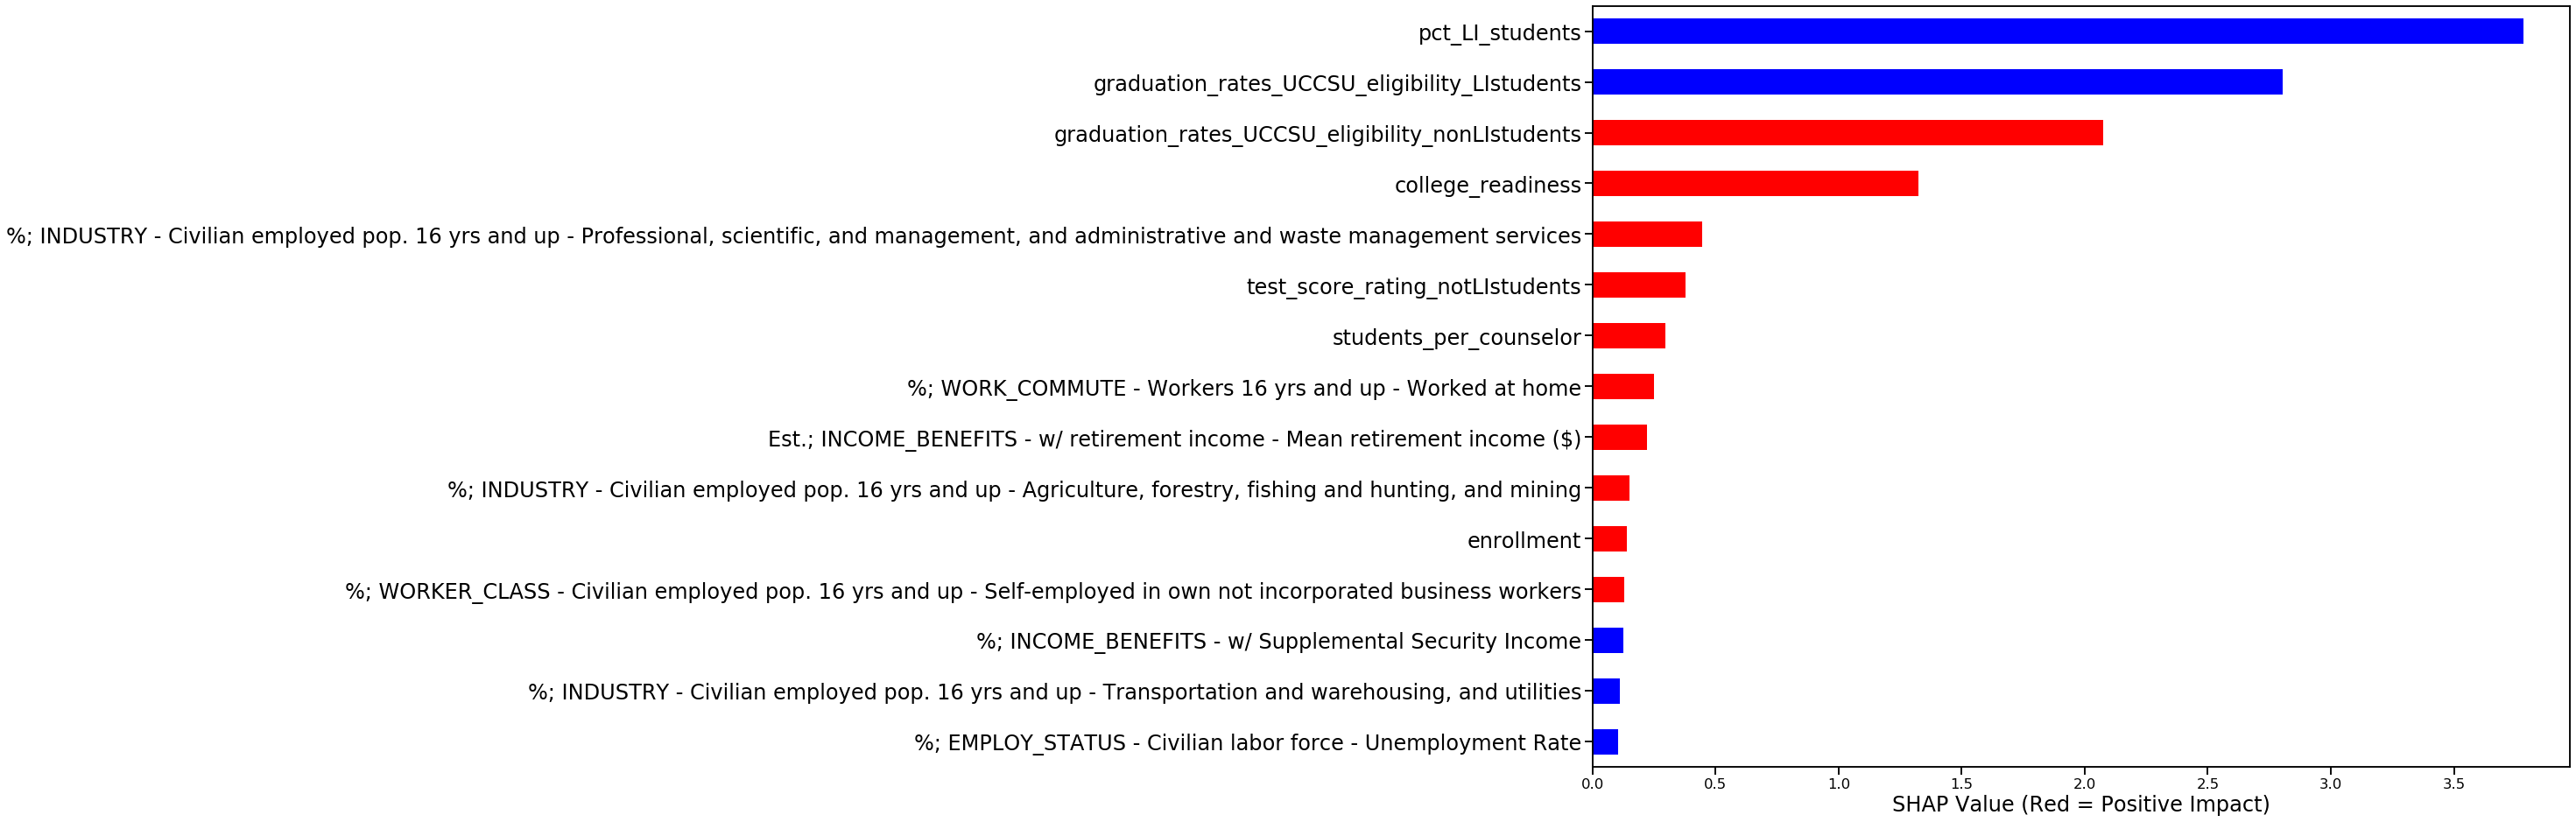

<IPython.core.display.Javascript object>

In [474]:
ABS_SHAP(shap_values, X_train_rf_gap, 15)

## Additional visualization

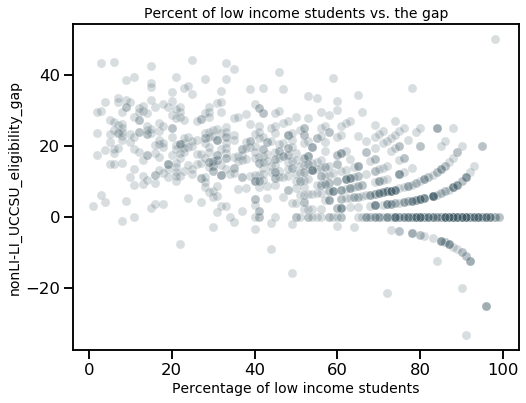

<IPython.core.display.Javascript object>

In [482]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

sns.scatterplot(
    data=df_state_info_gs_census,
    x="pct_LI_students",
    y="nonLI-LI_UCCSU_eligibility_gap",
    ax=ax1,
    alpha=0.2,
    color=B_slate,
    legend=False,
)
ax1.set_xlabel(
    "Percentage of low income students", fontsize=14
)
ax1.set_ylabel(
    "nonLI-LI_UCCSU_eligibility_gap", fontsize=14
)
ax1.set_title(
    "Percent of low income students vs. the gap", fontsize=14
);


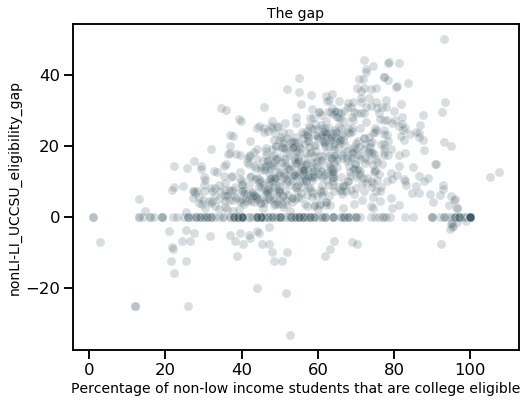

<IPython.core.display.Javascript object>

In [475]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

sns.scatterplot(
    data=df_state_info_gs_census,
    x="graduation_rates_UCCSU_eligibility_nonLIstudents",
    y="nonLI-LI_UCCSU_eligibility_gap",
    ax=ax1,
    alpha=0.2,
    color=B_slate,
    legend=False,
)
ax1.set_xlabel(
    "Percentage of non-low income students that are college eligible", fontsize=14
)
ax1.set_ylabel(
    "nonLI-LI_UCCSU_eligibility_gap", fontsize=14
)
ax1.set_title(
    "The gap", fontsize=14
);


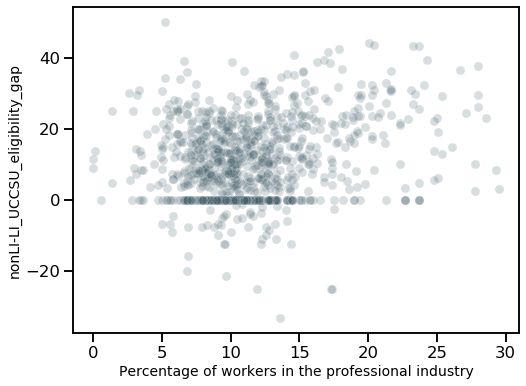

<IPython.core.display.Javascript object>

In [481]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 6))

sns.scatterplot(
    data=df_state_info_gs_census,
    x="%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services",
    y="nonLI-LI_UCCSU_eligibility_gap",
    ax=ax1,
    alpha=0.2,
    color=B_slate,
    legend=False,
)
ax1.set_xlabel(
    "Percentage of workers in the professional industry", fontsize=14
)
ax1.set_ylabel(
    "nonLI-LI_UCCSU_eligibility_gap", fontsize=14
)
ax1.set_title(
    "", fontsize=14
);


# RF regression, target: SPLICE and pct all students college eligible

In [449]:
df_state_info_gs_census.head()

Unnamed: 0        CDSCode NCESDist NCESSchool StatusType   County  \
0           0  1100170112607  0691051      10947     Active  Alameda   
1           1  1611190130229  0601770      00041     Active  Alameda   
2           2  1611190130625  0601770      08674     Active  Alameda   
3          23  1612590108944  0628050      10726     Active  Alameda   
4           3  1611270130450  0601860      00059     Active  Alameda   

                             District                                  School  \
0  Alameda County Office of Education  Envision Academy for Arts & Technology   
1                     Alameda Unified                            Alameda High   
2                     Alameda Unified                  Alternatives in Action   
3                     Oakland Unified       Lighthouse Community Charter High   
4                 Albany City Unified                             Albany High   

                    Street            StreetAbr  ... pct_nonLI_students  \
0      1515 Webster Street     1515 Webster St.  ...               33.0   
1         2200 Central Ave     2200 Central Ave  ...               82.0   
2        6221 East 17th St    6221 East 17th St  ...                NaN   
3     444 Hegenberger Road  444 Hegenberger Rd.  ...               20.0   
4  603 Key Route Boulevard  603 Key Route Blvd.  ...               83.0   

  est_LI_grade12_students est_nonLI_grade12_students est_UCCSU_eligible_all  \
0                   58.96                      29.04                  88.00   
1                   68.58                     312.42                 251.46   
2                     NaN                        NaN                  31.00   
3                   47.20                      11.80                  59.00   
4                   48.45                     236.55                 179.55   

  est_UCCSU_eligible_LI est_UCCSU_eligible_nonLI  \
0               58.9600                  29.0400   
1               34.2900                 217.1700   
2                   NaN                      NaN   
3               47.2000                  11.8000   
4               21.8025                 157.7475   

  graduation_rates_UCCSU_eligibility_nonLIstudents Magnet_cat_encoded  \
0                                       100.000000                0.0   
1                                        69.512195                0.0   
2                                              NaN                0.0   
3                                       100.000000                0.0   
4                                        66.686747                0.0   

  Charter_cat_encoded nonLI-LI_UCCSU_eligibility_gap  
0                   1                   0.000000e+00  
1                   0                   1.951220e+01  
2                   1                            NaN  
3                   1                   4.263256e-14  
4                   0                   2.168675e+01  

[5 rows x 233 columns]

<IPython.core.display.Javascript object>

In [685]:
df_state_info_gs_census.loc[:, "graduation_rates_UCCSU_eligibility_LI_all_diff"] = df_state_info_gs_census.loc[:, "graduation_rates_UCCSU_eligibility_LIstudents"] - df_state_info_gs_census.loc[:, "graduation_rates_UCCSU_eligibility_allStudents"]


<IPython.core.display.Javascript object>

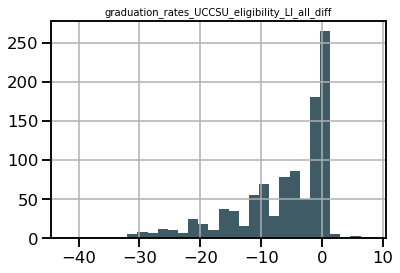

<IPython.core.display.Javascript object>

In [687]:
f, ax1 = plt.subplots()
hist_plot(
    df_state_info_gs_census, "graduation_rates_UCCSU_eligibility_LI_all_diff", ax1
)

In [694]:
target = "graduation_rates_UCCSU_eligibility_LI_all_diff"

<IPython.core.display.Javascript object>

In [695]:
X_rf_v1 = df_state_info_gs_census[all_features_filt_wcensuscheck_notarget].copy()
y_rf_v1 = df_state_info_gs_census[target].copy()

<IPython.core.display.Javascript object>

In [697]:
X_train_rf_v1, X_test_rf_v1, y_train_rf_v1, y_test_rf_v1 = get_split_data(
    X_rf_v1, y_rf_v1, 0.4
)

No. of total schools before splitting (no null values for feature set or target):  825


<IPython.core.display.Javascript object>

In [698]:
rf_v1, df_eval_v1 = run_randomforest_v0(
    X_train_rf_v1, y_train_rf_v1, X_test_rf_v1, y_test_rf_v1
)

<IPython.core.display.Javascript object>

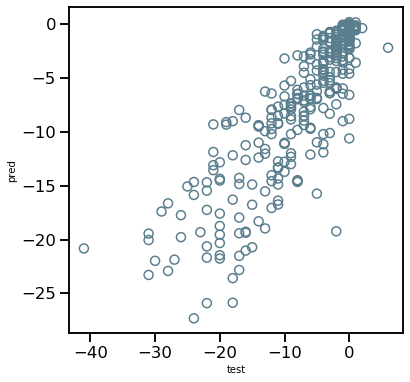

<IPython.core.display.Javascript object>

In [699]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
scatter_plot_open_circles(df_eval_v1, "test", "pred", ax1)

In [701]:
print("R2 score: ", rf_v1.score(X_test_rf_v1, y_test_rf_v1))

R2 score:  0.7376636998668289


<IPython.core.display.Javascript object>

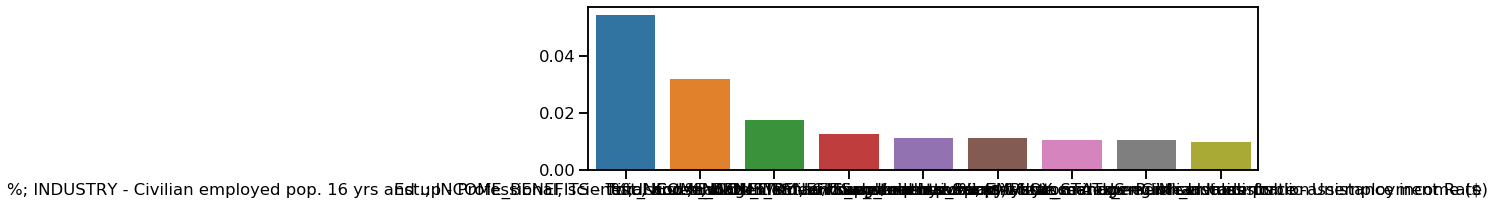

<IPython.core.display.Javascript object>

In [708]:
# Show most important features
features = X_train_rf_v1.columns.tolist()
feature_imp = pd.Series(rf_v1.feature_importances_, index=features).sort_values(
    ascending=False
)

# Creating a bar plot
plt.figure(figsize=(12, 3))
ax = sns.barplot(y=feature_imp[1:10], x=feature_imp.index[1:10])

In [703]:
feature_imp.head(10)

pct_LI_students                                                                                                                                    0.642368
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services    0.054382
Est.; INCOME_BENEFITS - Total households - Median household income ($)                                                                             0.031948
test_scores_math_LIstudents_n_students                                                                                                             0.017409
%; INCOME_BENEFITS - w/ Supplemental Security Income                                                                                               0.012607
avg_teacher_salary                                                                                                                                 0.011402
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Public admi

<IPython.core.display.Javascript object>

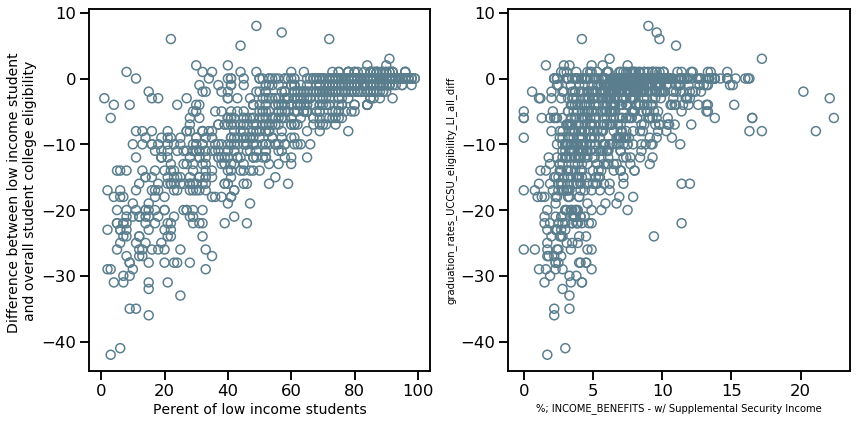

<IPython.core.display.Javascript object>

In [743]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
scatter_plot_open_circles(
    df_state_info_gs_census,
    "pct_LI_students",
    "graduation_rates_UCCSU_eligibility_LI_all_diff",
    ax1,
)
ax1.set_xlabel("Perent of low income students", fontsize=14)
ax1.set_ylabel(
    "Difference between low income student \nand overall student college eligibility",
    fontsize=14,
)


scatter_plot_open_circles(
    df_state_info_gs_census,
    "%; INCOME_BENEFITS - w/ Supplemental Security Income",
    "graduation_rates_UCCSU_eligibility_LI_all_diff",
    ax2,
)

plt.tight_layout()

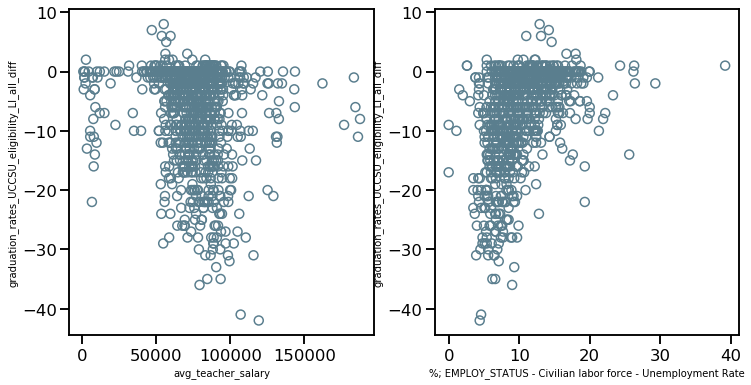

<IPython.core.display.Javascript object>

In [710]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
scatter_plot_open_circles(
    df_state_info_gs_census,
    "avg_teacher_salary",
    "graduation_rates_UCCSU_eligibility_LI_all_diff",
    ax1,
)

scatter_plot_open_circles(
    df_state_info_gs_census,
    "%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate",
    "graduation_rates_UCCSU_eligibility_LI_all_diff",
    ax2,
)

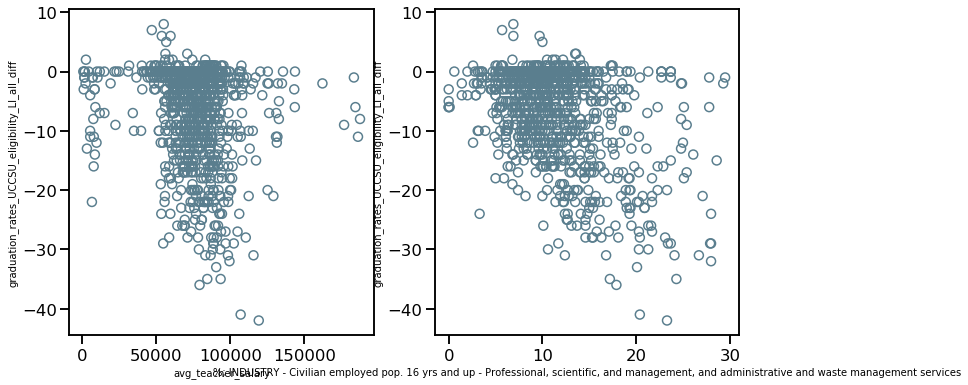

<IPython.core.display.Javascript object>

In [723]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
scatter_plot_open_circles(
    df_state_info_gs_census,
    "avg_teacher_salary",
    "graduation_rates_UCCSU_eligibility_LI_all_diff",
    ax1,
)

scatter_plot_open_circles(
    df_state_info_gs_census,
    "%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services",
    "graduation_rates_UCCSU_eligibility_LI_all_diff",
    ax2,
)

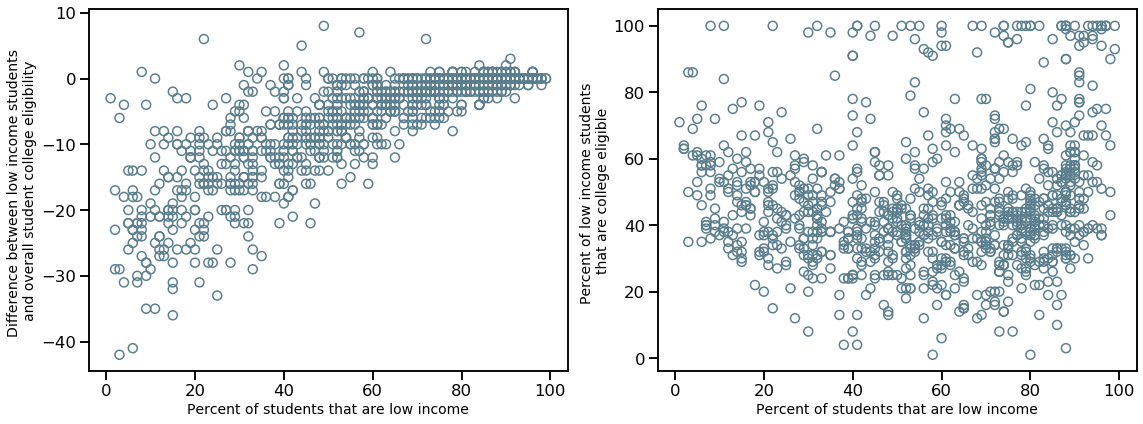

<IPython.core.display.Javascript object>

In [899]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
scatter_plot_open_circles(
    df_state_info_gs_census,
    "pct_LI_students",
    "graduation_rates_UCCSU_eligibility_LI_all_diff",
    ax1,
)
ax1.set_xlabel("Percent of students that are low income", fontsize=14)
ax1.set_ylabel(
    "Difference between low income students \nand overall student college eligibility",
    fontsize=14,
)


scatter_plot_open_circles(
    df_state_info_gs_census,
    "pct_LI_students",
    "graduation_rates_UCCSU_eligibility_LIstudents",
    ax2,
)

ax2.set_xlabel("Percent of students that are low income", fontsize=14)
ax2.set_ylabel(
    "Percent of low income students \nthat are college eligible", fontsize=14,
)
plt.tight_layout()

In [721]:
df_state_info_gs_census.sort_values(
    by="graduation_rates_UCCSU_eligibility_LI_all_diff", ascending=False
).loc[
    :,
    ["School", "City"]
    + all_features_filt_wcensuscheck_notarget
    + ["graduation_rates_UCCSU_eligibility_LIstudents", target],
].head(
    10
)

School             City  \
1009                      Fall River Junior-Senior High         McArthur   
482                            Redwood Academy of Ukiah            Ukiah   
174                         Lemoore Middle College High          Lemoore   
685                                 New Technology High       Sacramento   
1149            Marysville Charter Academy for the Arts       Marysville   
1015                                      Dunsmuir High         Dunsmuir   
654                            NOVA Academy - Coachella        Coachella   
850                         High Tech High North County       San Marcos   
377   Humanities and Arts (HARTS) Academy of Los Ang...      Harbor City   
307   Linda Esperanza Marquez High A Huntington Park...  Huntington Park   

      %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months  \
1009                                                2.5                        
482                                                14.0                        
174                                                11.1                        
685                                                16.5                        
1149                                               19.9                        
1015                                               13.2                        
654                                                23.0                        
850                                                 2.6                        
377                                                10.3                        
307                                                19.8                        

      %; INCOME_BENEFITS - w/ Social Security  \
1009                                     42.3   
482                                      33.8   
174                                      18.4   
685                                      32.4   
1149                                     31.2   
1015                                     48.3   
654                                      15.1   
850                                      31.8   
377                                      29.7   
307                                      23.4   

      %; INCOME_BENEFITS - w/ Supplemental Security Income  \
1009                                                9.0      
482                                                 9.6      
174                                                 4.2      
685                                                 9.8      
1149                                               11.0      
1015                                               17.2      
654                                                 6.2      
850                                                 2.9      
377                                                 4.9      
307                                                 7.5      

      Est.; INCOME_BENEFITS - Total households - Median household income ($)  \
1009                                                NaN                        
482                                             44596.0                        
174                                             48953.0                        
685                                             45801.0                        
1149                                            44852.0                        
1015                                            28241.0                        
654                                             37969.0                        
850                                             59778.0                        
377                                             52294.0                        
307                                             35917.0                        

      Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)  \
1009                                                NaN                           
482                                             30849.0      

<IPython.core.display.Javascript object>

# Statistical analysis, evaluate top and bottom performing schools

In [782]:
def run_mannwhitneyu(df, metric_col, bin_col):
    class0 = sorted(df[bin_col].unique())[0]
    class1 = sorted(df[bin_col].unique())[1]
    x = df.loc[df[bin_col] == class0, metric_col]
    y = df.loc[df[bin_col] == class1, metric_col]
    mwu_statistic, mwu_pval = mannwhitneyu(x, y, use_continuity=True, alternative=None)
    return mwu_pval

<IPython.core.display.Javascript object>

mean:  46.7021484375
mean +/- 1SD:  25.971879691038332 67.43241718396166


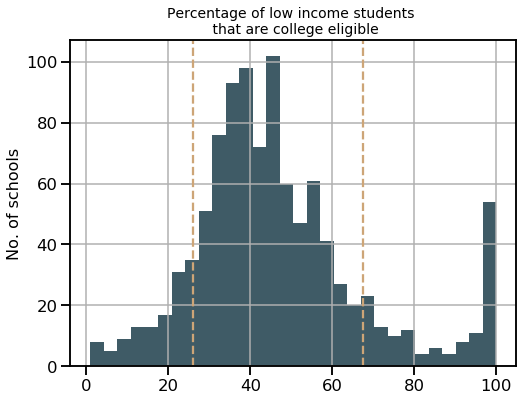

<IPython.core.display.Javascript object>

In [753]:
f, ax1 = plt.subplots(figsize=(8,6))
hist_plot(df_state_info_gs_census, "graduation_rates_UCCSU_eligibility_LIstudents", ax1)
ax1.set_ylabel("No. of schools", fontsize=16)
ax1.set_title("Percentage of low income students \n that are college eligible", fontsize=14);

target = df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"]
target_mean = target.mean()
target_sd = target.std()

# or top and bottom quantile

ax1.axvline(target_mean-target_sd, c=B_beige, linestyle="dashed")
ax1.axvline(target_mean+target_sd, c=B_beige, linestyle="dashed")

print("mean: ", target_mean)
print("mean +/- 1SD: ", target_mean - target_sd, target_mean + target_sd);


In [760]:
print(
    "No. of low performing schools: ",
    (
        df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"]
        < target_mean - target_sd
    ).sum(),
)

print(
    "No. of high performing schools: ",
    (
        df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"]
        > target_mean + target_sd
    ).sum(),
)

No. of low performing schools:  111
No. of high performing schools:  137


<IPython.core.display.Javascript object>

In [764]:
df_state_info_gs_census["LI_performance_status"] = "middle"

bool_low = df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"] < (
    target_mean - target_sd
)
df_state_info_gs_census.loc[bool_low, "LI_performance_status"] = "low"

bool_high = df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"] > (
    target_mean + target_sd
)
df_state_info_gs_census.loc[bool_high, "LI_performance_status"] = "high"

df_state_info_gs_census["LI_performance_status"].value_counts()

middle    904
high      137
low       111
Name: LI_performance_status, dtype: int64

<IPython.core.display.Javascript object>

In [771]:
feat_for_mw = all_features_filt_wcensuscheck[:-4]
feat_for_mw

['%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months',
 '%; INCOME_BENEFITS - w/ Social Security',
 '%; INCOME_BENEFITS - w/ Supplemental Security Income',
 'Est.; INCOME_BENEFITS - Total households - Median household income ($)',
 'Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)',
 'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)',
 '%; WORK_COMMUTE - Workers

<IPython.core.display.Javascript object>

In [774]:
status2keep = ["low", "high"]

df_state_info_gs_census_forMW = df_state_info_gs_census.loc[
    df_state_info_gs_census["LI_performance_status"].isin(status2keep),
    feat_for_mw + ["LI_performance_status"],
].copy()

<IPython.core.display.Javascript object>

In [775]:
df_state_info_gs_census_forMW.head()

%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months  \
0                                                 9.2                        
2                                                28.4                        
3                                                28.4                        
13                                                9.9                        
19                                                4.5                        

    %; INCOME_BENEFITS - w/ Social Security  \
0                                      24.0   
2                                      20.0   
3                                      20.0   
13                                     29.0   
19                                     25.8   

    %; INCOME_BENEFITS - w/ Supplemental Security Income  \
0                                                16.0      
2                                                13.4      
3                                                13.4      
13                                                8.1      
19                                                5.5      

    Est.; INCOME_BENEFITS - Total households - Median household income ($)  \
0                                             32993.0                        
2                                             31903.0                        
3                                             31903.0                        
13                                            76773.0                        
19                                            86757.0                        

    Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)  \
0                                             29027.0                           
2                                             19269.0                           
3                                             19269.0                           
13                                            20501.0                           
19                                            20687.0                           

    Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)  \
0                                              5055.0                                                   
2                                              5347.0                                                   
3                                              5347.0                                                   
13                                             4077.0                                                   
19                                             4531.0                                                   

    %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage  \
0                                                82.2                                      
2                                                80.2                                      
3                                                80.2                                      
13                                               90.3                                      
19                                               90.4                                      

    %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage  \
0                                                41.3                                                           
2                                                48.5                                                           
3                                                48.5                                                           
13                                               29.4                                                           
19                                               29.6                                                           

    %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs 

<IPython.core.display.Javascript object>

In [811]:
df_sig_features = pd.DataFrame()
df_sig_features["feature"] = None
df_sig_features["raw_pval"] = None


for i, feature in enumerate(feat_for_mw):
    mwu_pval_feature = run_mannwhitneyu(
        df_state_info_gs_census_forMW, feature, "LI_performance_status"
    )
    if mwu_pval_feature < 0.05:
        df_sig_features.loc[i, "feature"] = feature
        df_sig_features.loc[i, "raw_pval"] = mwu_pval_feature

df_sig_features = df_sig_features.sort_values(
    by="raw_pval", ascending=True
).reset_index()

bonferroni_reject, bonferroni_p_val_corrected = multitest.multipletests(
    df_sig_features["raw_pval"], alpha=0.05, method="bonferroni"
)[0:2]

df_sig_features["corr_p_val_rej"] = bonferroni_reject
df_sig_features["corr_p_val"] = bonferroni_p_val_corrected

<IPython.core.display.Javascript object>

In [831]:
df_sig_features.loc[df_sig_features["corr_p_val_rej"], ["feature", "corr_p_val"]]

feature   corr_p_val
0   %; WORK_COMMUTE - Workers 16 yrs and up - Publ...  5.07987e-19
1   %; INDUSTRY - Civilian employed pop. 16 yrs an...  7.23522e-17
2             %; INCOME_BENEFITS - w/ Social Security  5.22535e-14
3   %; WORKER_CLASS - Civilian employed pop. 16 yr...  1.01559e-13
4                      test_scores_english_LIstudents  4.72221e-13
5                                 Charter_cat_encoded  2.54253e-12
6   %; INDUSTRY - Civilian employed pop. 16 yrs an...  1.23895e-11
7   %; EMPLOY_STATUS - Pop. 16 yrs and up - Not in...  1.76531e-11
8   %; INDUSTRY - Civilian employed pop. 16 yrs an...  4.63625e-11
9   %; INDUSTRY - Civilian employed pop. 16 yrs an...  2.34242e-09
10                        test_scores_math_LIstudents   1.0673e-08
11                       test_score_rating_LIstudents  2.19737e-07
12  %; EMPLOY_STATUS - Females 16 yrs and up - In ...  1.86992e-06
13  %; WORK_COMMUTE - Workers 16 yrs and up - Car,...  4.88815e-06
14  %; HEALTH_INS_COVERAGE - Civilian noninstituti...   0.00195228
15  %; INDUSTRY - Civilian employed pop. 16 yrs an...   0.00352555

<IPython.core.display.Javascript object>

In [834]:
[print(i, feature) for i, feature in enumerate(df_sig_features["feature"])]

0 %; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
1 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services
2 %; INCOME_BENEFITS - w/ Social Security
3 %; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Private wage and salary workers
4 test_scores_english_LIstudents
5 Charter_cat_encoded
6 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration
7 %; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force
8 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Information
9 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining
10 test_scores_math_LIstudents
11 test_score_rating_LIstudents
12 %; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed
13 %; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone
14 %; HEALTH_INS_COVERAGE - 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<IPython.core.display.Javascript object>

## First pass of boxplots - by order of significance

%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services
%; INCOME_BENEFITS - w/ Social Security


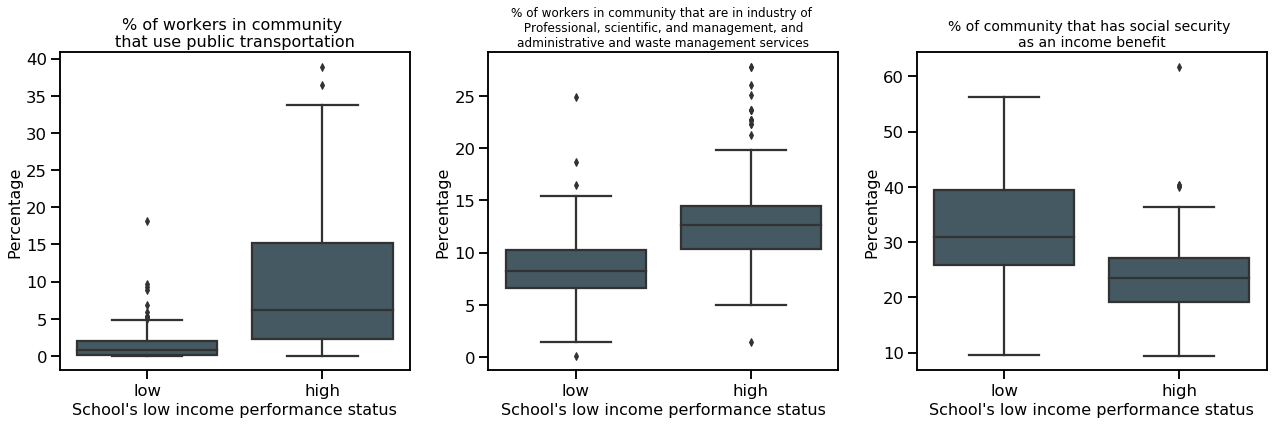

<IPython.core.display.Javascript object>

In [833]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [0,1,2]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of workers in community \nthat use public transportation", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of workers in community that are in industry of \n Professional, scientific, and management, and \nadministrative and waste management services", fontsize=12)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax3,
)

ax3.set_title("% of community that has social security \nas an income benefit", fontsize=14)
ax3.set_xlabel("School's low income performance status", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)


plt.tight_layout();



%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Private wage and salary workers
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration
%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force


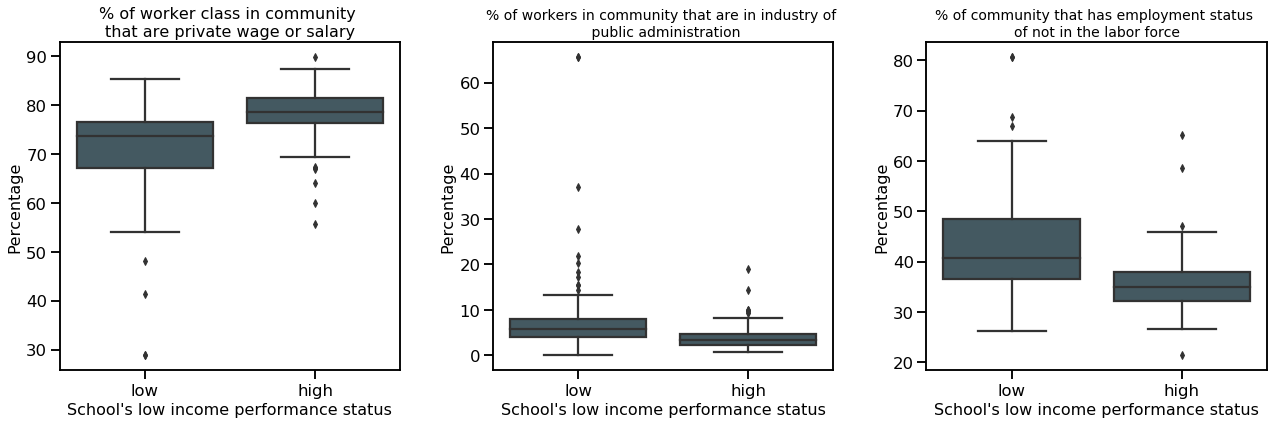

<IPython.core.display.Javascript object>

In [838]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [3, 6, 7]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title(
    "% of worker class in community \nthat are private wage or salary", fontsize=16
)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title(
    "% of workers in community that are in industry of \n public administration",
    fontsize=14,
)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax3,
)

ax3.set_title(
    "% of community that has employment status \nof not in the labor force", fontsize=14
)
ax3.set_xlabel("School's low income performance status", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)

plt.tight_layout()

%; INDUSTRY - Civilian employed pop. 16 yrs and up - Information
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed


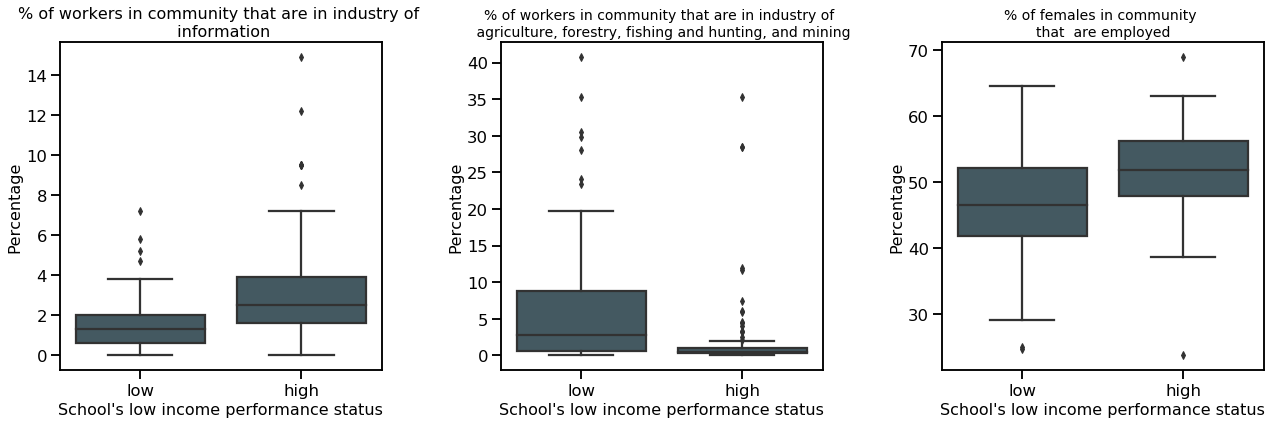

<IPython.core.display.Javascript object>

In [840]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [8, 9, 12]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title(
    "% of workers in community that are in industry of \n information", fontsize=16
)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title(
    "% of workers in community that are in industry of \n agriculture, forestry, fishing and hunting, and mining",
    fontsize=14,
)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax3,
)

ax3.set_title("% of females in community \nthat  are employed", fontsize=14)
ax3.set_xlabel("School's low income performance status", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)

plt.tight_layout()

%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Manufacturing


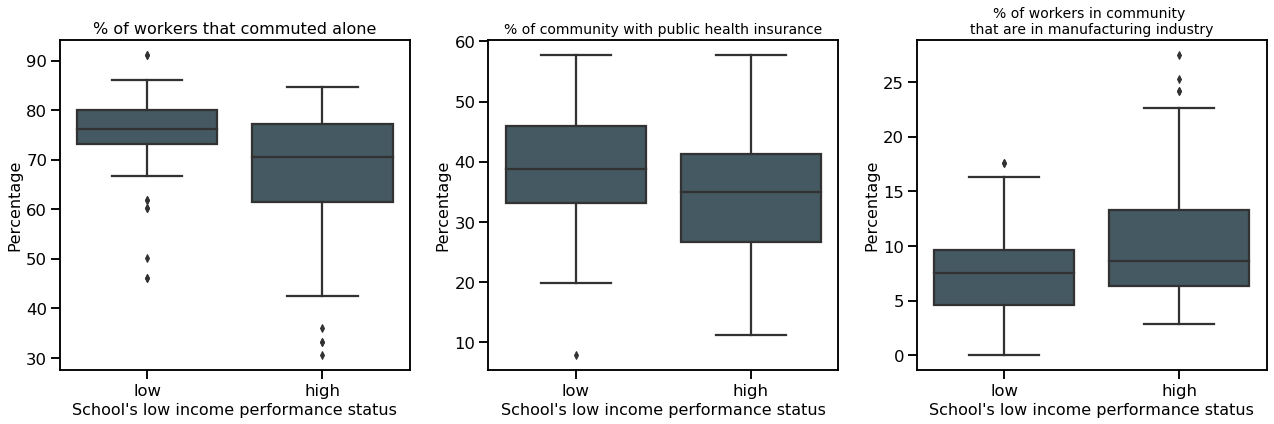

<IPython.core.display.Javascript object>

In [842]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [13, 14, 15]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of workers that commuted alone", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title(
    "% of community with public health insurance", fontsize=14,
)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax3,
)

ax3.set_title(
    "% of workers in community \nthat are in manufacturing industry", fontsize=14
)
ax3.set_xlabel("School's low income performance status", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)

plt.tight_layout()

## Second pass of boxplots - by category

%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Information
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Manufacturing


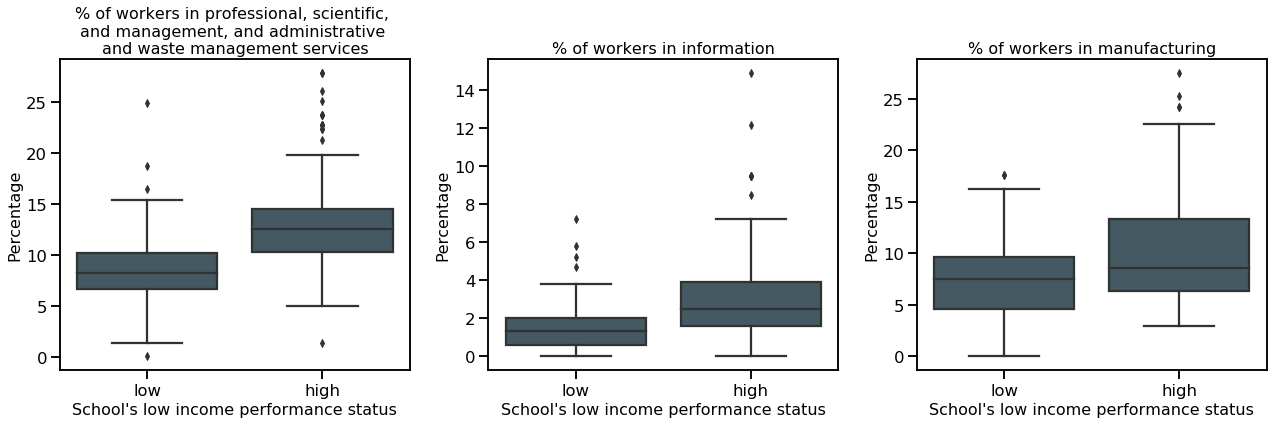

<IPython.core.display.Javascript object>

In [851]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [1,8,15]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of workers in professional, scientific, \nand management, and administrative \nand waste management services", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of workers in information", fontsize=16)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax3,
)

ax3.set_title("% of workers in manufacturing", fontsize=16)
ax3.set_xlabel("School's low income performance status", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();


%; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining


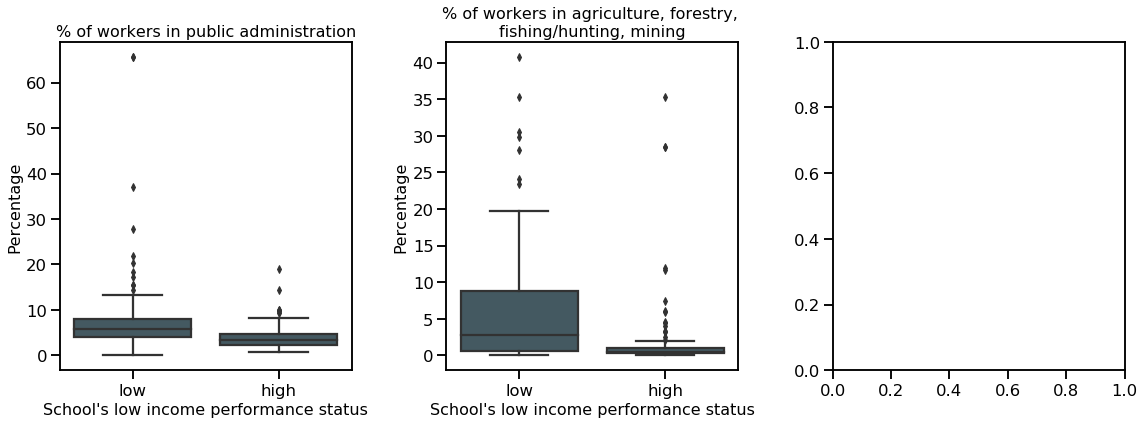

<IPython.core.display.Javascript object>

In [858]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

feature_rank_to_plot = [6,9]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of workers in public administration", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of workers in agriculture, forestry, \nfishing/hunting, mining", fontsize=16)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();



%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed


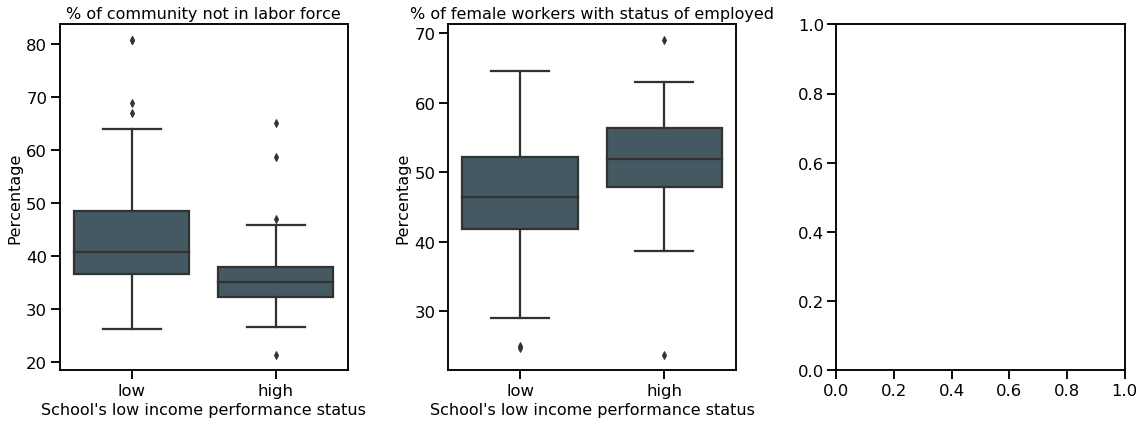

<IPython.core.display.Javascript object>

In [856]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

feature_rank_to_plot = [7,12]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of community not in labor force", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of female workers with status of employed", fontsize=16)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();


%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone


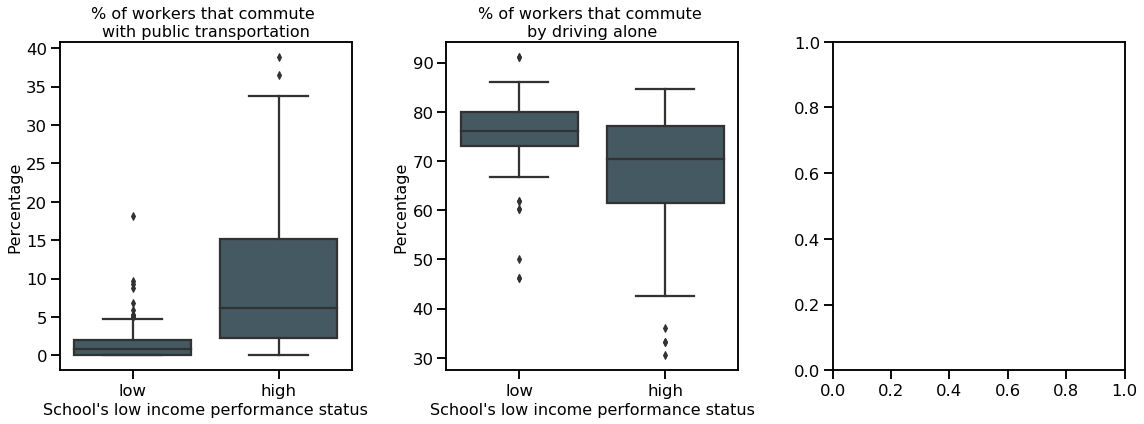

<IPython.core.display.Javascript object>

In [855]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

feature_rank_to_plot = [0,13]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of workers that commute \nwith public transportation", fontsize=16)
ax1.set_xlabel("School's low incomae performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of workers that commute \nby driving alone", fontsize=16)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();


%; INCOME_BENEFITS - w/ Social Security
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage


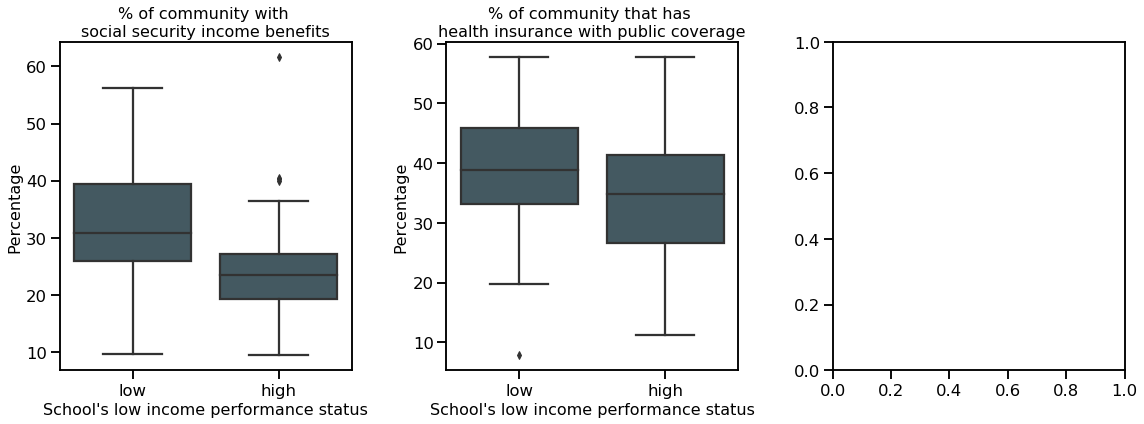

<IPython.core.display.Javascript object>

In [861]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

feature_rank_to_plot = [2,14]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of community with \nsocial security income benefits", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of community that has \nhealth insurance with public coverage", fontsize=16)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();



# ---